janomeについて

https://note.nkmk.me/python-janome-tutorial/

globについて

https://techacademy.jp/magazine/18928

In [1]:
import collections
from janome.tokenizer import Tokenizer

def parse_voc(text):
    t = Tokenizer()
    
    ##助動詞 or 助詞 + 別の品詞 + 、。 が来るまで合体させる
    vocs = []
    voc = ""##vocを合体させる部分
    before_voc = ""##前回のvoc字ズラのまま
    before_nomal_voc = ""##前回のvoc言い切り型
    before_word_type = ""
    remove = ["助動詞","助詞"]
    ##split_norm = ["数","代名詞"]##名刺でも取り除く(分解する分類)
    
    #\u3000は全角空白
    ##ここで分割する文字達(一部 file_read部分で置き換え)
    split_char = [" ","　","する","ある","いる","なる","この","これ","その","それ","そこ","そう","れる","ない"]
    
    find_quot = False ## "の内部か 判定
    
    ## 2番目の削除タイプ判定
    second_remove = ["空白","非自立"]## ~のようだ の ようを消す

    
    for token in t.tokenize(text):#[”。”]は無理矢理処理数を増やすため
        ##print(token)
        now_word_type, now_word_type2 = token.part_of_speech.split(",")[0:2]
        
        ## ダブルクオーテーションの内部処理(一つの単語化)
        if find_quot:
            if token.surface != '"' and token.surface.find("\n") == -1:
                voc += token.surface
            else:
                print(voc)
                vocs.append(voc)
                voc = ""
                find_quot = False
            
            ## これ以降の処理を無視
            continue
    
    
        if token.surface.find('"') != -1:
            ## 1分割中の 複数のダブルクオーテーションを見つける
            for word in token.surface:
                if word == '"':
                    if find_quot:
                        find_quot = False
                        print("many quot:  ",voc)
                        if voc:
                            vocs.append(voc)
                        voc = ""
                    
                    else:
                        find_quot = True
                                      
                        ##初回に入った場合の処理
                        if voc:##空文字以外
                            vocs.append(voc)
                        voc = ""
                        before_word_type = ""
                        before_nomal_voc = ""
            
                ## 繋げる文字
                else:
                    voc += word        
        
        ##助詞・助動詞の処理 + 、。の処理 + 改行や空白(\u3000)の時の処理
        elif now_word_type in remove or token.base_form in split_char or now_word_type2 in second_remove:
            voc += before_nomal_voc##動詞を切りのいい形で代入
            if voc:##空語(助詞・助動詞で生まれる)を取り除く
                vocs.append(voc)
            voc = ''
            before_word_type = ""
            before_nomal_voc = ""
            
           
        
        ##前回と同じ品詞 = 分割ミス として一つ前の変換値を繋げる + 名詞-数字の連鎖を断つための処理(この時、前が接頭辞かを確認すべき)
        elif (before_word_type == "接頭詞" and now_word_type2 == "数") or before_word_type == now_word_type:
            voc += before_voc
            ##初期化
            before_voc = token.surface ##今の単語の字ズラままを入れる
            before_nomal_voc = token.base_form ##今の単語を読み切りの形に
            before_word_type = now_word_type##品詞変更
        else:
            voc += before_nomal_voc
            ##空語(助詞・助動詞で生まれる)を取り除く 
            if voc:
                vocs.append(voc)##前回までの単語を追加
                voc=""
            
            ##初期化
            before_voc = token.surface ##今の単語の字ズラままを入れる
            before_nomal_voc = token.base_form ##今の単語を読み切りの形に
            before_word_type = now_word_type##品詞変更
            
    ##集めた単語を返す
    return vocs


## 正規表現
https://uxmilk.jp/41416

http://www-creators.com/archives/2612

In [2]:
## 話毎に単語分割を行う
import re
import glob

## 各章毎にこの関数が呼ばれる
def concat_voc(text_list):
    ## 空白に変更する記号 間違えてくっつかせないため(半角のカッコはエスケープする必要あり) \.{2,}は二回以上 .が出る場合、捨てる
    subtract_mark = r"'|[|]|「|」|『|』|【|】|（|）|｛|｝|\(|\)|’|……|●|■|◆|◇|!|！|\?|？|、|。|\.{2,}|(\\u3000)"


    voc_list = []
    
    ##print(file_names)
    for text in text_list:
            ## 全角の ” を 半角 "に変更(戻す)
        text = text.replace('”','"').replace('“','"')
            
            ## parseがうまく行かなくなる部分を削除
        text = re.sub(subtract_mark," ",text)

        voc_list += parse_voc(text)
        
    return voc_list

### WordCloud
https://qiita.com/Senple/items/1ad08b1a7ac9560bef62

### フォントダウンロード(今回は はんなり明朝)
https://jp.stanby.com/media/free-font/

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import random

fpath = "hannari/Hannari.otf"##日本語文字化けを防ぐ(自分でダウンロードしたもの)

##フォルダ(章)ごとの word_listを生成
def make_cloud_and_lists(syosetu_dict):
    
    voc_lists= []
    before_vocs = [""]#前回までの章の単語リストを結合する
    for chapter_name, text_list in syosetu_dict.items():
        voc_list = concat_voc(text_list)
        voc_lists.append(voc_list)##返すリストに分割したリストを追加する
        
    
        words = ""
        for word in voc_list:
            words = words + " " + word
        
    
        wordcloud =  WordCloud(background_color="white",
                               font_path=fpath,
                               width=800,
                               height=500).generate(words)
        ##WordCloudの表示
        print(chapter_name)
        plt.figure(figsize=(30,24))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        
        unique_list = voc_list + []##リストを複製する(複製しないと あとで before_vocsに入れる時 単語数が変わるため)
        ##print(unique_list is voc_list)##値渡し出来たか チェック
        
        
        
        ##### ユニーク画像処理(前回までに現れないほど 単語が大きくなる？)
        
        length = len(unique_list)
        ## これまでに出てきた単語を減らす
        for voc in random.choices(before_vocs, k=length):
            
            if voc in unique_list:
                unique_list.remove(voc)
                
        ## 今の章の単語リストを合体させる
        before_vocs = before_vocs + voc_list
            
        words = ""
        for word in unique_list:
            words = words + " " + word
        
        
        wordcloud =  WordCloud(background_color="white",
                               font_path=fpath,
                               width=800,
                               height=500).generate(words)
        ##WordCloudの表示
        print(chapter_name + "  ユニーク多め")
        plt.figure(figsize=(30,24))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        
    
        ##出現単語回数を出力
        c = collections.Counter(voc_list)
        print(c)
        print("\n\n")
    
    return voc_lists

### スクレイピングする

なろうスクレイピング例

https://karupoimou.hatenablog.com/entry/2019/07/02/220557

In [5]:
import requests
from bs4 import BeautifulSoup
import re
import time

## 話毎に 文字列で返す
def syosetu_string(url, not_serial=False, soup=None):
    return_str = ""
 
    ## 一話以上ある場合(soupを使用して、１段階下のリンクに降りる必要がある)
    if not not_serial:
        ## requests の設定ユーザーエージェントの設定必須らしい
        headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:61.0) Gecko/20100101 Firefox/61.0"}
        r = requests.get(url="https://ncode.syosetu.com/"+url,headers=headers)
        soup = BeautifulSoup(r.text,"html")
    
    ## 本文の入れ子を抽出
    contents = soup.find("div", id="novel_honbun")
    ## ルビ部分は rubyタグでまとめられているため、その内容を削除する
    for ruby in contents.find_all("ruby"):
        if ruby.find("rb") == None:
            ## 既に or 元々 ルビを振る部分がなくなっている(念のため)
            ruby.string = ""
        else:
            ## ルビを振りたかった文字を入れる
            ruby.string = ruby.find("rb").text


    ## "\n"の要素が出てくるので削除
    html_list = [content for content in contents
                                    if content != "\n"]
    
    ## ライン毎に文字を追加する
    for html in html_list:
        ##改行(空文字)が隠れている場合、付け足す
        if html.text == "":
            return_str += "\n"
        else:
            return_str += html.text + "\n"
        
        
    
    ## これで逮捕されない?? はず...
    ## https://syosetu.com/robots.txt
    ## でのbingbot用クロールは 3と書いてあるより
    time.sleep(4)
        
    return return_str

In [6]:
## 小説をkey:章名 として、その中の話を文字リストで返す
import re

def syosetu_url_dict(c="",chap_bool=True,not_serial=False):
    ##返す値
    novel_tilte = None
    title_list = [] ##各話のタイトル
    syosetu_dict = {}
    
    
    ## nコードの urlを入れる
    if c[0] == "n":
        syosetu_url = "https://ncode.syosetu.com/"+c
    
    elif c[0:4] == "http":##url全て書かれているとして、そのまま利用
        syosetu_url = c
        
    else:
        return  novel_title, title_list, {"error":["error"]}##見つけれないため
    
    
    ## requests の設定ユーザーエージェントの設定必須らしい
    headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:61.0) Gecko/20100101 Firefox/61.0"}

    ## urlをスクレイピング
    r = requests.get(url=syosetu_url, headers=headers)
    soup = BeautifulSoup(r.text,'html')


    ##一応スリープする(一気にこの関数を繰り返してもいいように)
    ##   + 次の処理で直ぐに一つ目の話を見ないように
    time.sleep(2)
    
    ## 小説タイトルを取得
    novel_title = soup.find("p",class_="novel_title").text

    
    ##### 一話完結の処理
    if not_serial:
        text = syosetu_string(syosetu_url,not_serial,soup)
        syosetu_dict[novel_title] = [text]
        
        return novel_title, title_list, syosetu_dict
        
    
    ## 物語を章で分けるための下処理
    html_list = [content for content in soup.find("div", class_="index_box").contents
                        if content != "\n"]##何故か "\n" のtag?が取られるため削除
    now_chapter = "-0章?"##章設定してない場合用

    for html in html_list:
        ## 章を利用して取得する場合
        if chap_bool:
            ## 章のtag(これ以降の章が出るまで、listにある話は同じ章とする)
            if html["class"][0] == "chapter_title":
                syosetu_dict[html.text] = []
                now_chapter = html.text
        
            ## novel_sublist2のなかに 各話のurlがある
            elif html["class"][0] == "novel_sublist2":
                ## 章が取得されない場合 => "-0章?" で無理矢理  章を生成
                if now_chapter not in syosetu_dict:
                    syosetu_dict[now_chapter] = []
                
                ## 今処理しようとしている 章名 + 話の名前 を出力
                print(now_chapter,html.find("a").text)
                
                ##各話タイトルの取得
                title_list.append(html.find("a").text)
            
                ## 一話ごとに一つの文字列にして返却
                text = syosetu_string(html.find("a")["href"])
                syosetu_dict[now_chapter].append(text)
             
            
        ## 章を利用せず、各話毎に分ける場合
        else:
            ## 各話の要素か調べる
            if html["class"][0] == "novel_sublist2":
                ## 題名取得
                story_name = html.find("a").text
                print(story_name)
                
                ##各話タイトルを取得
                title_list.append(story_name)

                text = syosetu_string(html.find("a")["href"])
                syosetu_dict[story_name] = [text]
    
    
    
    return novel_title, title_list, syosetu_dict

In [7]:
## syosetu_dictの txtデータ化関数
import os

def make_syosetu_txt(syosetu_dict, title_list, chap_bool=True, not_serial=False, s_name="not get"):
    ## ディレクトリを生成
    syosetu_path = "./"+s_name
    ## 既にディレクトリがあるかの確認
    if not os.path.isdir(syosetu_path):
        os.mkdir(syosetu_path)
        
    
    ## 短編の場合の処理
    if not_serial:
        for title, text_list in syosetu_dict.items():
            ## 小説を txtデータとして保存
            with open(syosetu_path+"/"+title+".txt","w") as f:
                f.write(text_list[0])
            
            ## 念のため,title名を txtデータ化(titles_txtとして同じように参照するため)
            with open(syosetu_path+"/titles.txt","w") as f:
                f.write(title+"\n")##下の処理で、必ず 改行を含むように処理するため
            
        return
        
        
    
    ## 章の順番を改行毎に保存するtxtを生成するため
    chapters_txt = ""
    
    ## 各話のタイトル の出現順番を改行毎に保存する
    titles_txt = ""
    
    
    
   
    for chapter_name, chapter_stories in syosetu_dict.items():
        ## 章名の名前文字列を生成
        chapters_txt += chapter_name +"\n"
        
        for syosetu_text in chapter_stories:
            ## txtファイルを各話で作る
            
            ## 各話に一致する名前を取得 + 書き込み する
            title_name = title_list.pop(0)
            titles_txt += title_name + "\n"
        
            #### 章を保存できた場合は、章毎にディレクトリを作成
            ## 各章でディレクトリを生成
            if chap_bool:
                dir_name = syosetu_path+"/"+chapter_name
                ## 既にディレクトリがあるかの確認
                if not os.path.isdir(dir_name):
                    os.mkdir(dir_name)##ディレクトリ生成
             
            ## 章がない場合は、この小説のディレクトリ内に全てのtxtをおく
            else:
                dir_name = syosetu_path ##小説のディレクトリのままにする
            
            ### 小説の各話 txtデータ化
            # with で開くと f.close()が不要らしい
            with open(dir_name+"/"+title_name+".txt",'w') as f:
                f.write(syosetu_text)
                
            
        #print(chapters_txt)##確認用
    
    ## これを利用して、どのディレクトリを順に見るべきかを調べる
    if chap_bool:##章が存在しない場合は、この処理をしない
        with open(syosetu_path+"/chapters.txt","w") as f:
            f.write(chapters_txt[:-1])##最後の改行を消去
            
    
    ## 各話の順番を表す txtを生成
    with open(syosetu_path+"/titles.txt","w") as f:
        f.write(titles_txt[:-1])##最後の改行を消去
    
        
    return

In [8]:
## スクレイピング -> txtデータ化 -> cloud表示 をひとまとめにした関数
## 返り値は cloud生成時の単語リスト

def scr_cloud_txt(url, chap_bool=True, not_serial=False):
    
    ## スクレイピング
    title, title_list, syosetu_dict = syosetu_url_dict(url, chap_bool=chap_bool, not_serial = not_serial)

    ##print(title)
    if title != None:
        ## txtデータ化 
        make_syosetu_txt(syosetu_dict, title_list, chap_bool=chap_bool, not_serial=not_serial, s_name=title)
        
        ## word cloud化
        word_list = make_cloud_and_lists(syosetu_dict)
    else:
        print("not found!",url)
        return []
    
    return word_list

序章　落果ふたつ 【　罪闇　】
序章　落果ふたつ 【　命花　】
序章　落果ふたつ 【　双芽　】
一章　全にして一なる花咲く園 旧暦（西暦）３２０５年　某日　～兄妹の追憶～
一章　全にして一なる花咲く園 第１節　落果追う者たち　Ⅰ
一章　全にして一なる花咲く園 第１節　落果追う者たち　Ⅱ
一章　全にして一なる花咲く園 第１節　落果追う者たち　Ⅲ
一章　全にして一なる花咲く園 第２節　存在しないもの　Ⅰ
一章　全にして一なる花咲く園 第２節　存在しないもの　Ⅱ
一章　全にして一なる花咲く園 第２節　存在しないもの　Ⅲ
一章　全にして一なる花咲く園 第２節　存在しないもの　Ⅳ
一章　全にして一なる花咲く園 第３節　ゆえに落果は落果たる　Ⅰ
一章　全にして一なる花咲く園 第３節　ゆえに落果は落果たる　Ⅱ
一章　全にして一なる花咲く園 第３節　ゆえに落果は落果たる　Ⅲ
一章　全にして一なる花咲く園 第３節　ゆえに落果は落果たる　Ⅳ
二章　落果の芽吹く場所へと 西暦２０ＸＸ年　某所　～ある少年の追憶～
二章　落果の芽吹く場所へと 第１節　田園の長閑　Ⅰ
二章　落果の芽吹く場所へと 第１節　田園の長閑　Ⅱ
二章　落果の芽吹く場所へと 第２節　決意と迷いと　Ⅰ
二章　落果の芽吹く場所へと 第２節　決意と迷いと　Ⅱ
二章　落果の芽吹く場所へと 第３節　大地にこそ根を　Ⅰ
二章　落果の芽吹く場所へと 第３節　大地にこそ根を　Ⅱ
三章　万花の園に朽花一輪 西暦２０ＸＸ年　某所　～ある少女の追憶～
三章　万花の園に朽花一輪 第１節　命が咲くには　Ⅰ
三章　万花の園に朽花一輪 第１節　命が咲くには　Ⅱ
三章　万花の園に朽花一輪 第１節　命が咲くには　Ⅲ
三章　万花の園に朽花一輪 第１節　命が咲くには　Ⅳ
三章　万花の園に朽花一輪 第１節　命が咲くには　Ⅴ
三章　万花の園に朽花一輪 第２節　原初の殺人者　Ⅰ
三章　万花の園に朽花一輪 第２節　原初の殺人者　Ⅱ
三章　万花の園に朽花一輪 第３節　母とは子とは　Ⅰ
三章　万花の園に朽花一輪 第３節　母とは子とは　Ⅱ
三章　万花の園に朽花一輪 第４節　地に還る者、還ったはずの者　Ⅰ
三章　万花の園に朽花一輪 第４節　地に還る者、還ったはずの者　Ⅱ
三章　万花の園に朽花一輪 第４節　地に還る者、還ったはずの者　Ⅲ
四章　祖花の想い、幼芽の願い 西暦２０

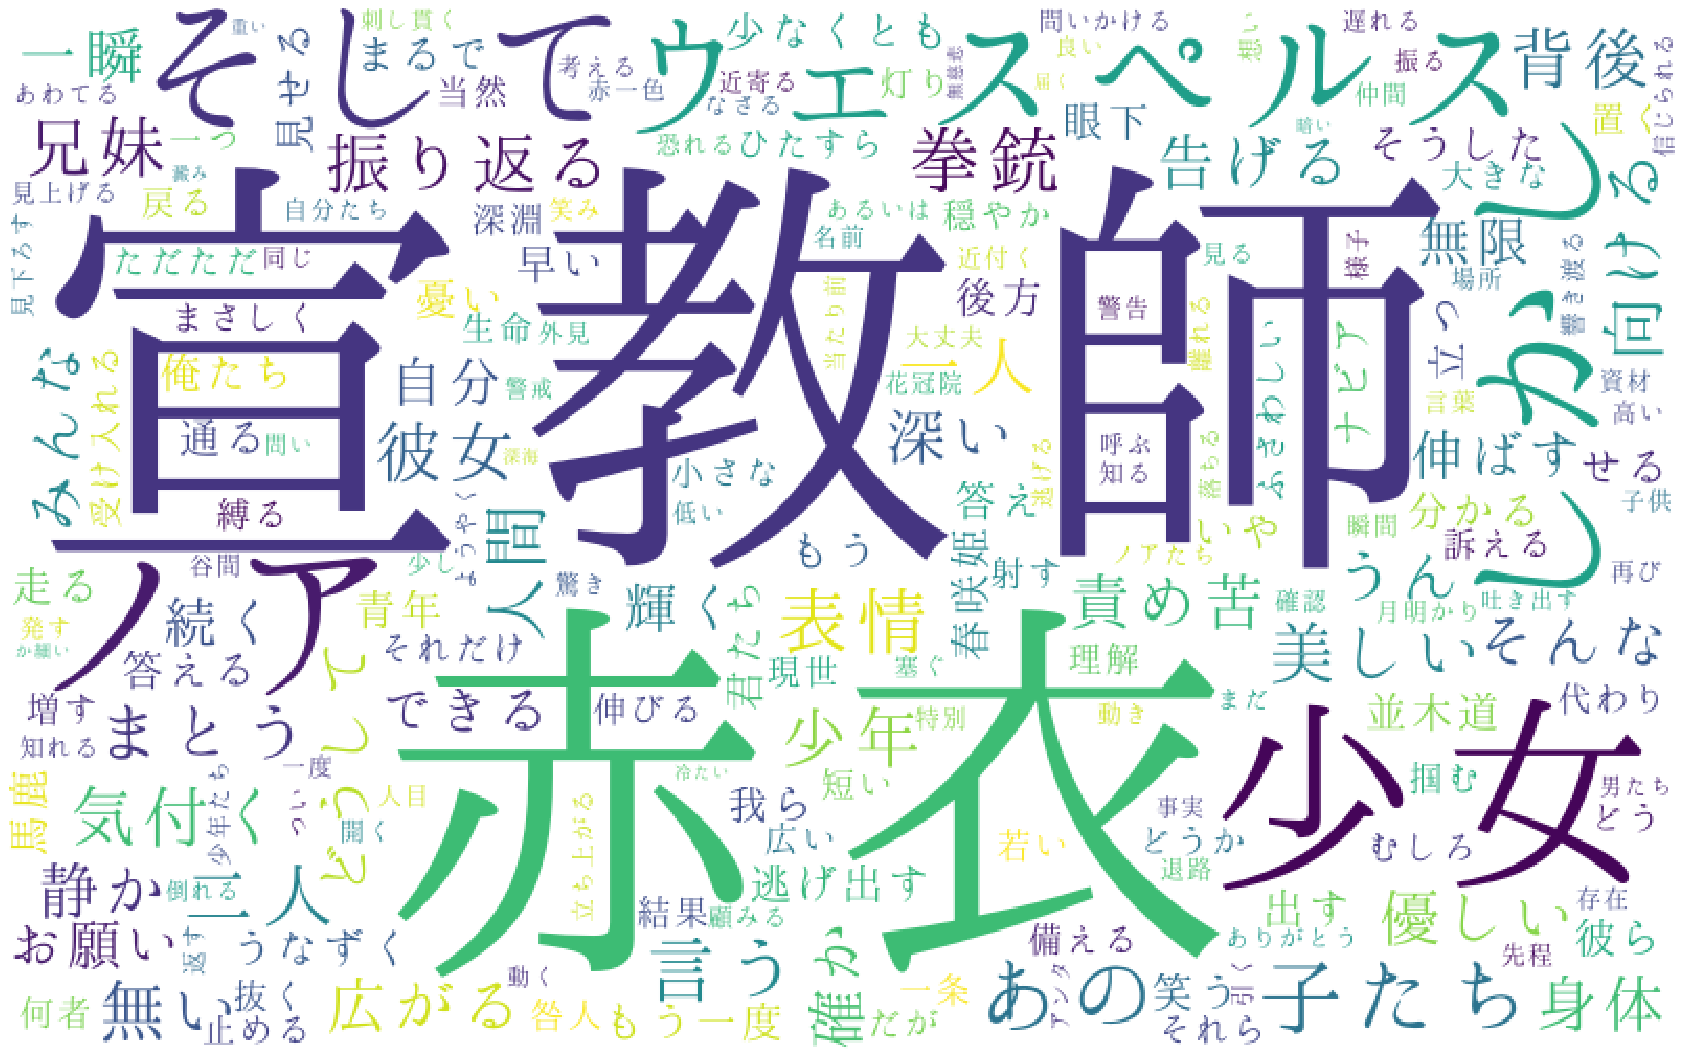

序章　落果ふたつ  ユニーク多め


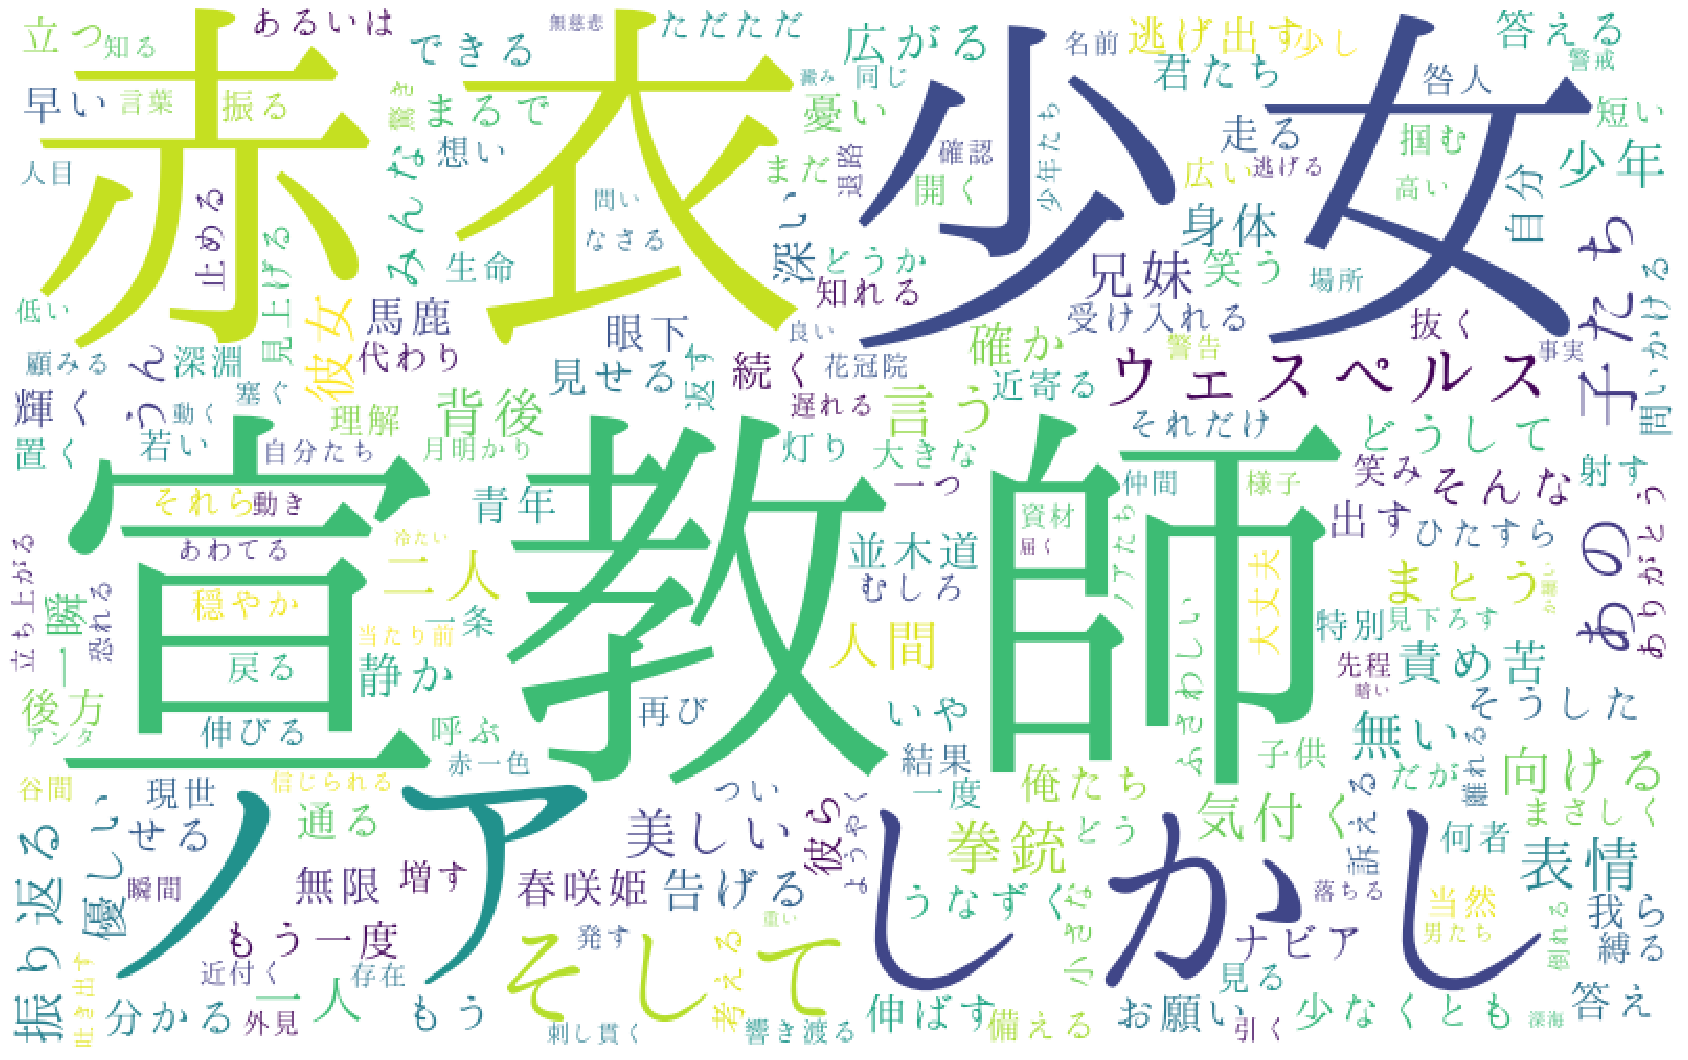

Counter({'――': 53, '彼': 25, '男': 25, '宣教師': 21, '赤衣': 18, '少女': 17, '声': 15, 'ノア': 13, '闇': 10, 'しかし': 10, '手': 10, 'あの': 9, '子たち': 9, 'そして': 9, 'ウェスペルス': 9, '何': 9, 'さ': 8, '顔': 6, '表情': 6, '目': 6, '君': 6, '言う': 6, '二人': 6, '拳銃': 6, 'まとう': 5, '無い': 5, '美しい': 5, '一人': 5, '彼女': 5, '気付く': 5, '背後': 5, '人間': 5, '少年': 5, '兄妹': 5, '振り返る': 5, '誰': 5, '兄': 5, '向ける': 5, '光': 4, '広がる': 4, '責め苦': 4, '確か': 4, 'どうして': 4, '糸': 4, '告げる': 4, 'そんな': 4, '静か': 4, '身体': 4, '優しい': 4, '今': 4, '前': 4, '首': 4, 'うん': 4, '口': 4, '深い': 4, 'みんな': 4, '気': 4, '一瞬': 4, '《': 3, 'お願い': 3, '――》': 3, '無限': 3, '自分': 3, '続く': 3, 'できる': 3, '輝く': 3, '伸ばす': 3, '少なくとも': 3, '並木道': 3, '髪': 3, '笑う': 3, '街': 3, '眼下': 3, '憂い': 3, 'せる': 3, '青年': 3, '立つ': 3, '逃げ出す': 3, 'うなずく': 3, '答える': 3, 'もう一度': 3, '分かる': 3, '出す': 3, '答え': 3, 'そうした': 3, '我ら': 3, '春咲姫': 3, 'まるで': 3, '後方': 3, '走る': 3, '彼ら': 3, '通る': 3, '妹': 3, '先': 3, 'もう': 3, '馬鹿': 3, 'ナビア': 3, '俺たち': 3, '君たち': 3, '見せる': 3, '早い': 3, 'いや': 3, '銃': 3, '私': 3, '射す': 2, '一条': 2, '縛る': 

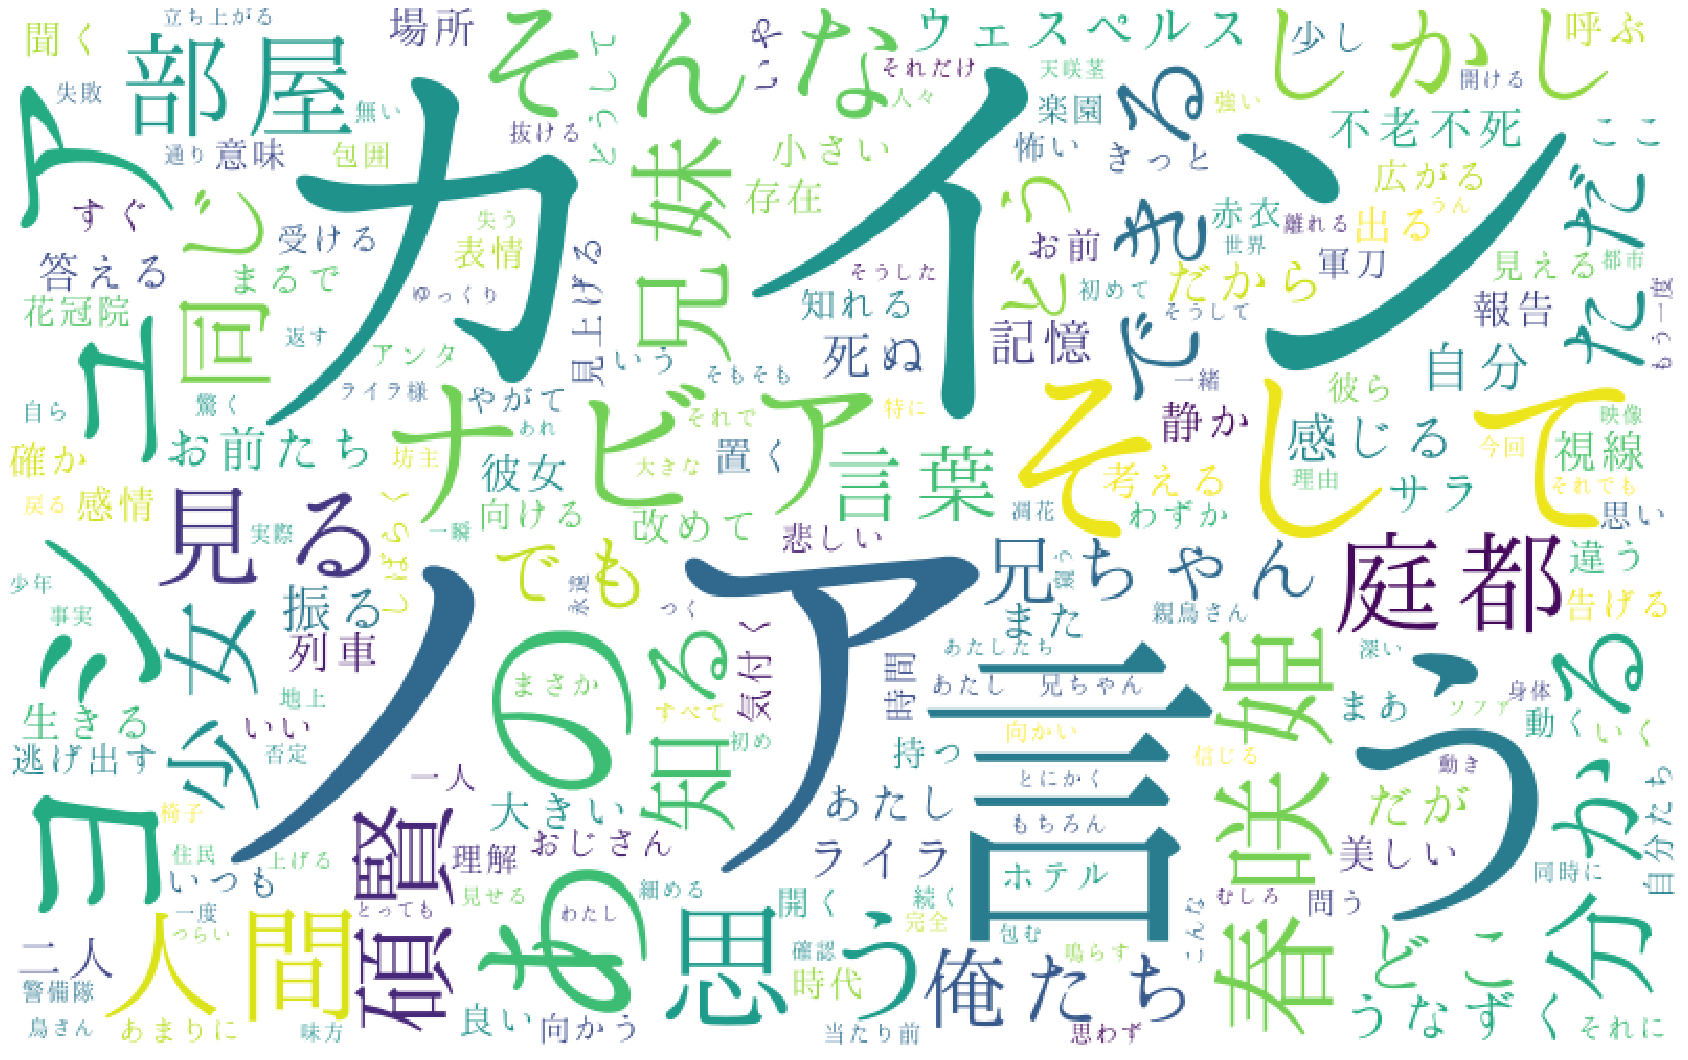

一章　全にして一なる花咲く園  ユニーク多め


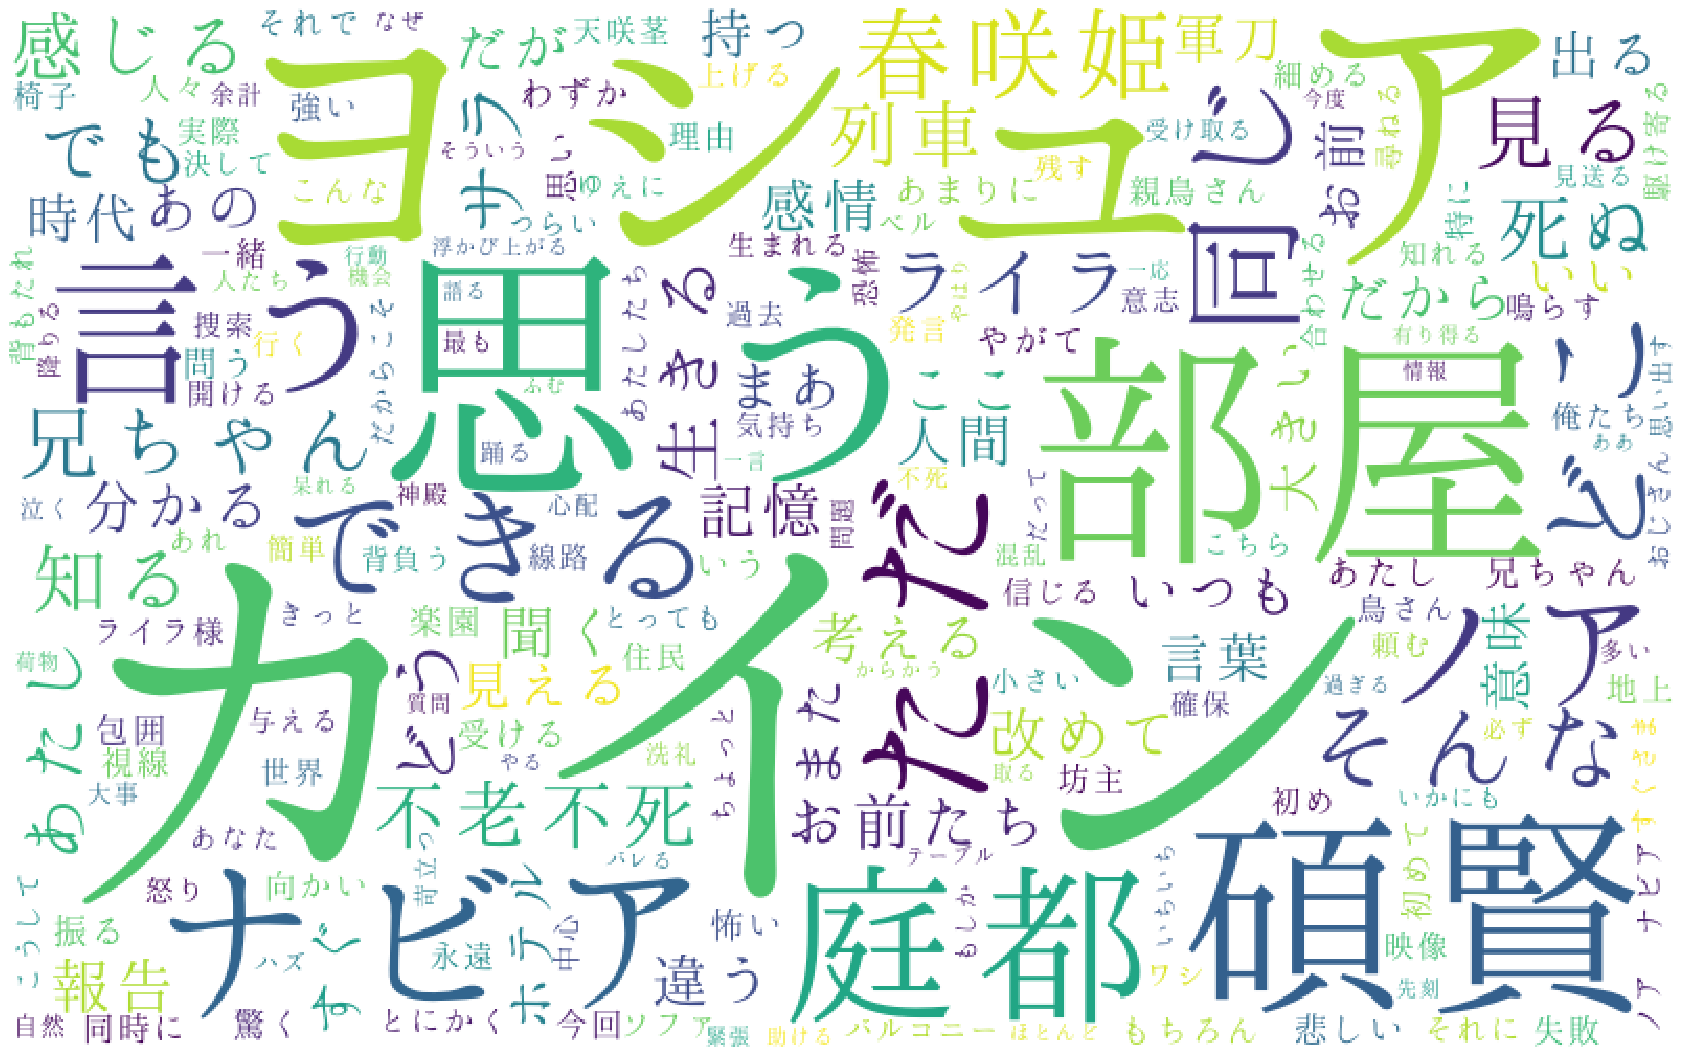

Counter({'――': 260, 'カイン': 102, 'ノア': 99, '言う': 57, 'そして': 50, 'ヨシュア': 50, 'あの': 49, 'ナビア': 48, 'そんな': 42, '何': 42, '人': 42, 'お': 41, '思う': 40, '春咲姫': 36, '彼': 36, '人間': 33, '手': 33, '分かる': 32, 'しかし': 32, '庭都': 31, '顔': 30, 'できる': 30, '見る': 29, '部屋': 29, '兄ちゃん': 28, '今': 28, '兄妹': 28, '碩賢': 28, '同じ': 25, '知る': 25, 'ただ': 25, '少女': 24, '俺たち': 23, 'どう': 23, 'あたし': 22, 'どこ': 22, '目': 22, 'でも': 21, '言葉': 21, 'うなずく': 20, '私': 20, '感じる': 19, '心': 19, '自分': 19, '死': 19, '前': 19, '男': 19, 'ウェスペルス': 19, 'だから': 18, '振る': 18, '死ぬ': 18, 'だが': 18, '首': 17, '記憶': 17, 'お前たち': 17, '二人': 16, 'ライラ': 16, '口': 16, '考える': 15, '不老不死': 15, '身': 15, 'サラ': 15, '静か': 14, '花': 14, '先': 14, '大きい': 14, 'また': 14, '視線': 14, '列車': 14, '場所': 13, '知れる': 13, '生きる': 13, '俺': 13, '彼女': 13, '答える': 13, '出る': 12, '声': 12, '呼ぶ': 12, '姿': 12, '赤衣': 12, '報告': 12, 'ここ': 12, '改めて': 12, '聞く': 11, '違う': 11, 'すぐ': 11, '誰': 11, '少し': 11, '確か': 11, '小さい': 11, 'いや': 11, '美しい': 11, '存在': 11, '主': 11, '置く': 11, 'さ': 11, '感情': 11, '名': 11,

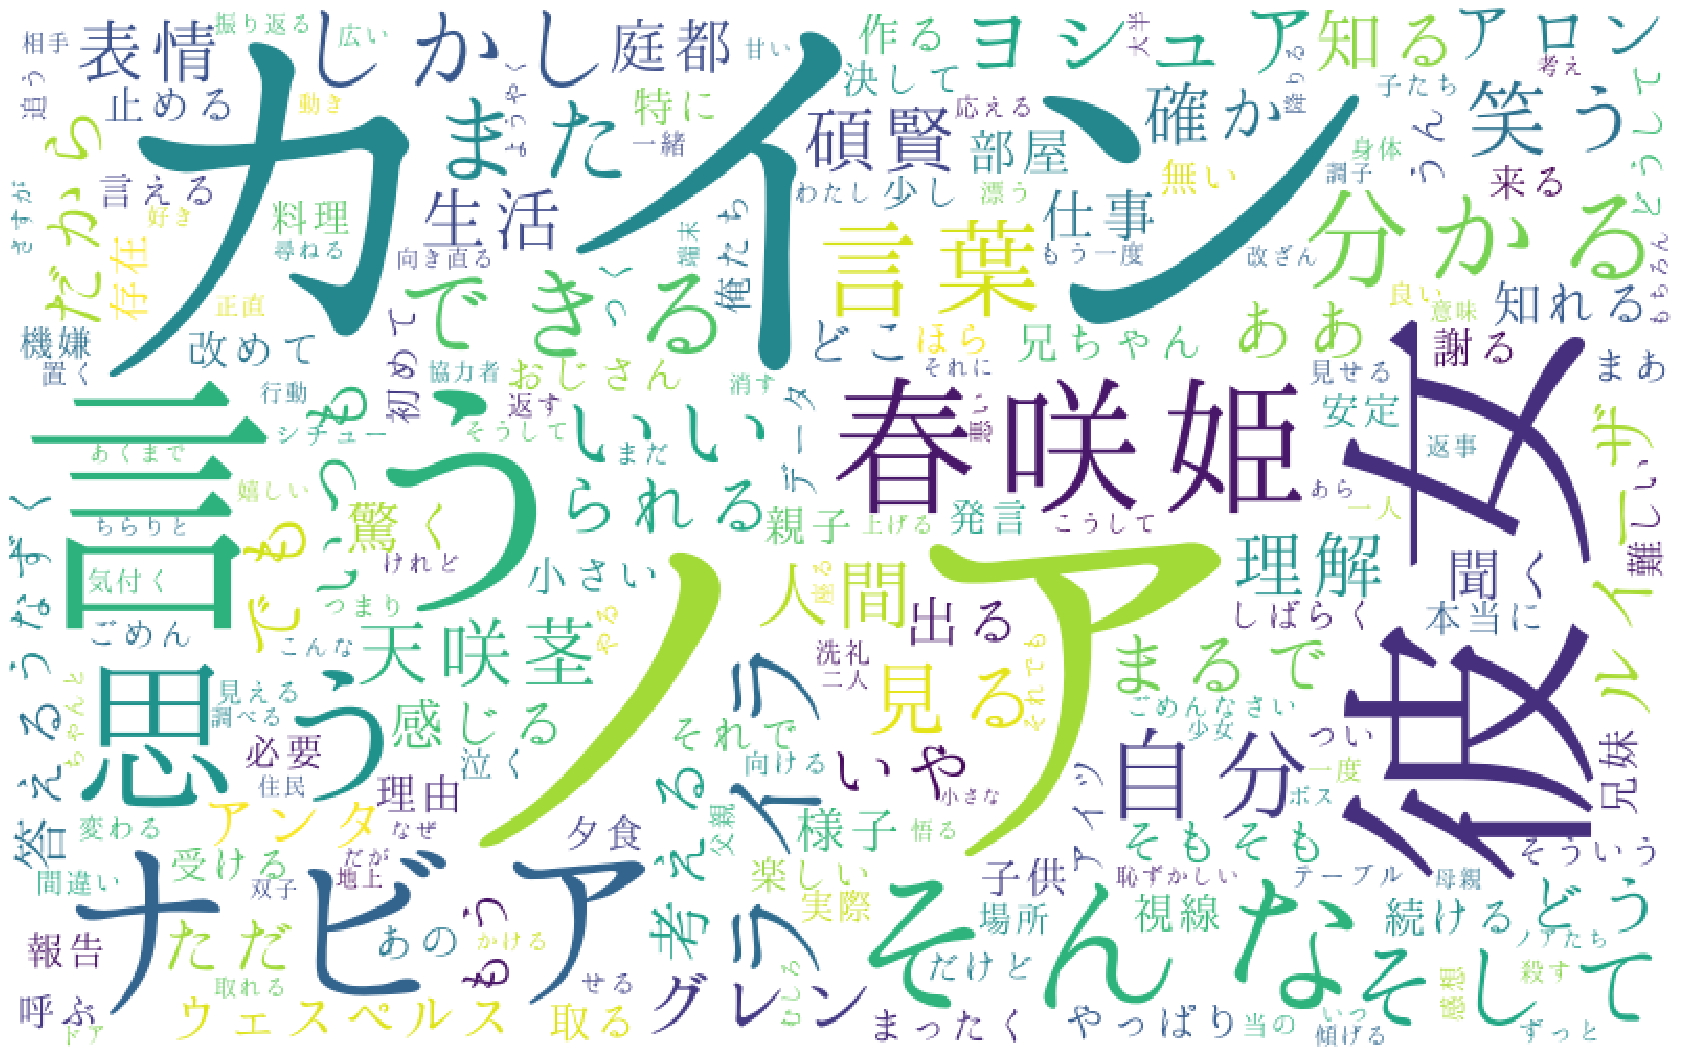

二章　落果の芽吹く場所へと  ユニーク多め


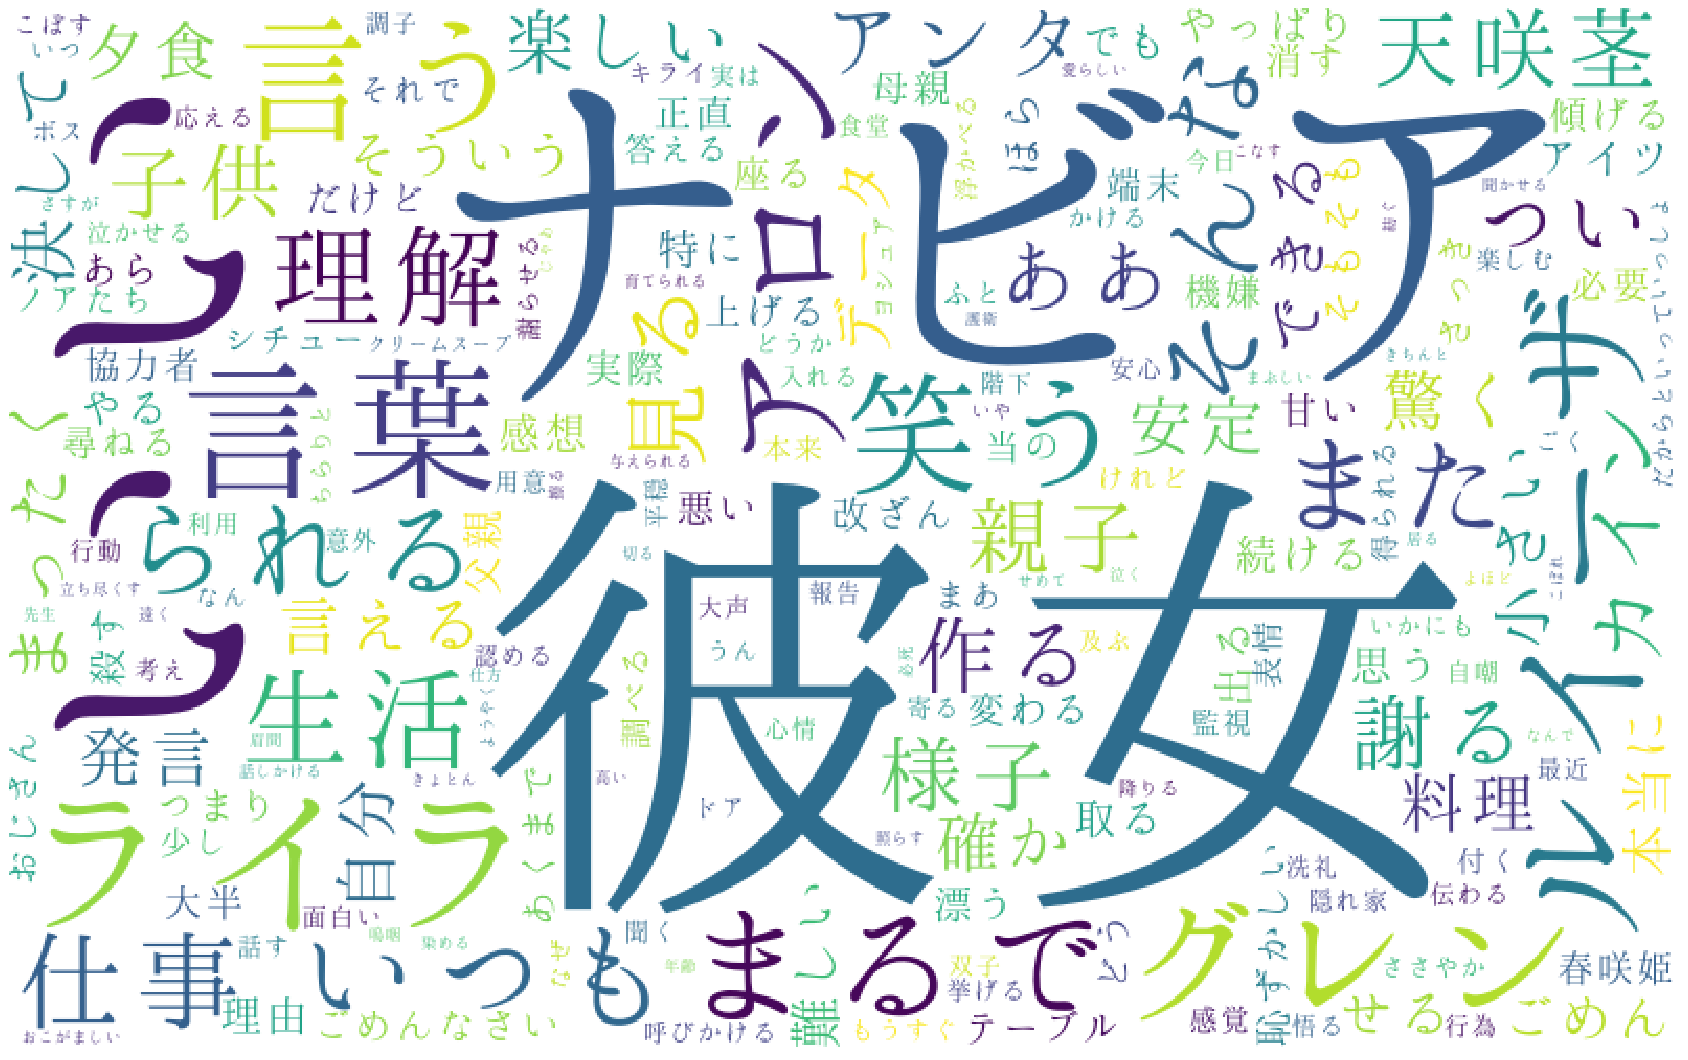

Counter({'――': 153, 'ノア': 57, 'カイン': 55, '僕': 48, '言う': 45, '彼女': 44, 'ナビア': 43, 'そんな': 31, '思う': 30, 'お': 28, '何': 27, '春咲姫': 24, '分かる': 23, 'ライラ': 23, 'できる': 21, '顔': 21, '言葉': 21, 'いい': 19, 'しかし': 18, '自分': 18, 'また': 18, 'そして': 18, 'ヨシュア': 18, '手': 17, '笑う': 17, '今': 16, '見る': 16, '気': 14, 'でも': 14, '天咲茎': 14, '話': 14, '人間': 13, 'ルイーザ': 13, '俺': 13, 'グレン': 13, 'まるで': 12, '理解': 12, 'だから': 12, 'いつも': 12, '碩賢': 12, '確か': 11, 'られる': 11, 'どう': 11, '表情': 11, '知る': 11, 'ああ': 11, 'アロン': 11, 'いや': 11, '生活': 11, 'ただ': 10, '考える': 10, '名': 10, 'アンタ': 10, '庭都': 10, '目': 10, 'もう': 9, 'さ': 9, '仕事': 9, '感じる': 9, '声': 9, '答える': 9, '出る': 9, '聞く': 9, '驚く': 9, 'どこ': 9, 'ー': 9, '彼': 9, 'ウェスペルス': 9, 'つい': 8, '知れる': 8, '姿': 8, '様子': 8, '君': 8, 'そもそも': 8, 'うなずく': 8, '部屋': 8, '兄ちゃん': 8, '妹': 8, '口': 8, '私': 8, '作る': 8, '存在': 7, '子供': 7, '続ける': 7, '謝る': 7, '改めて': 7, '視線': 7, 'うん': 7, '止める': 7, '理由': 7, '小さい': 7, 'やっぱり': 7, 'それで': 7, '特に': 7, 'おじさん': 7, '兄妹': 7, '取る': 7, 'あの': 7, '親子': 7, '呼ぶ': 6, '楽しい': 6, '

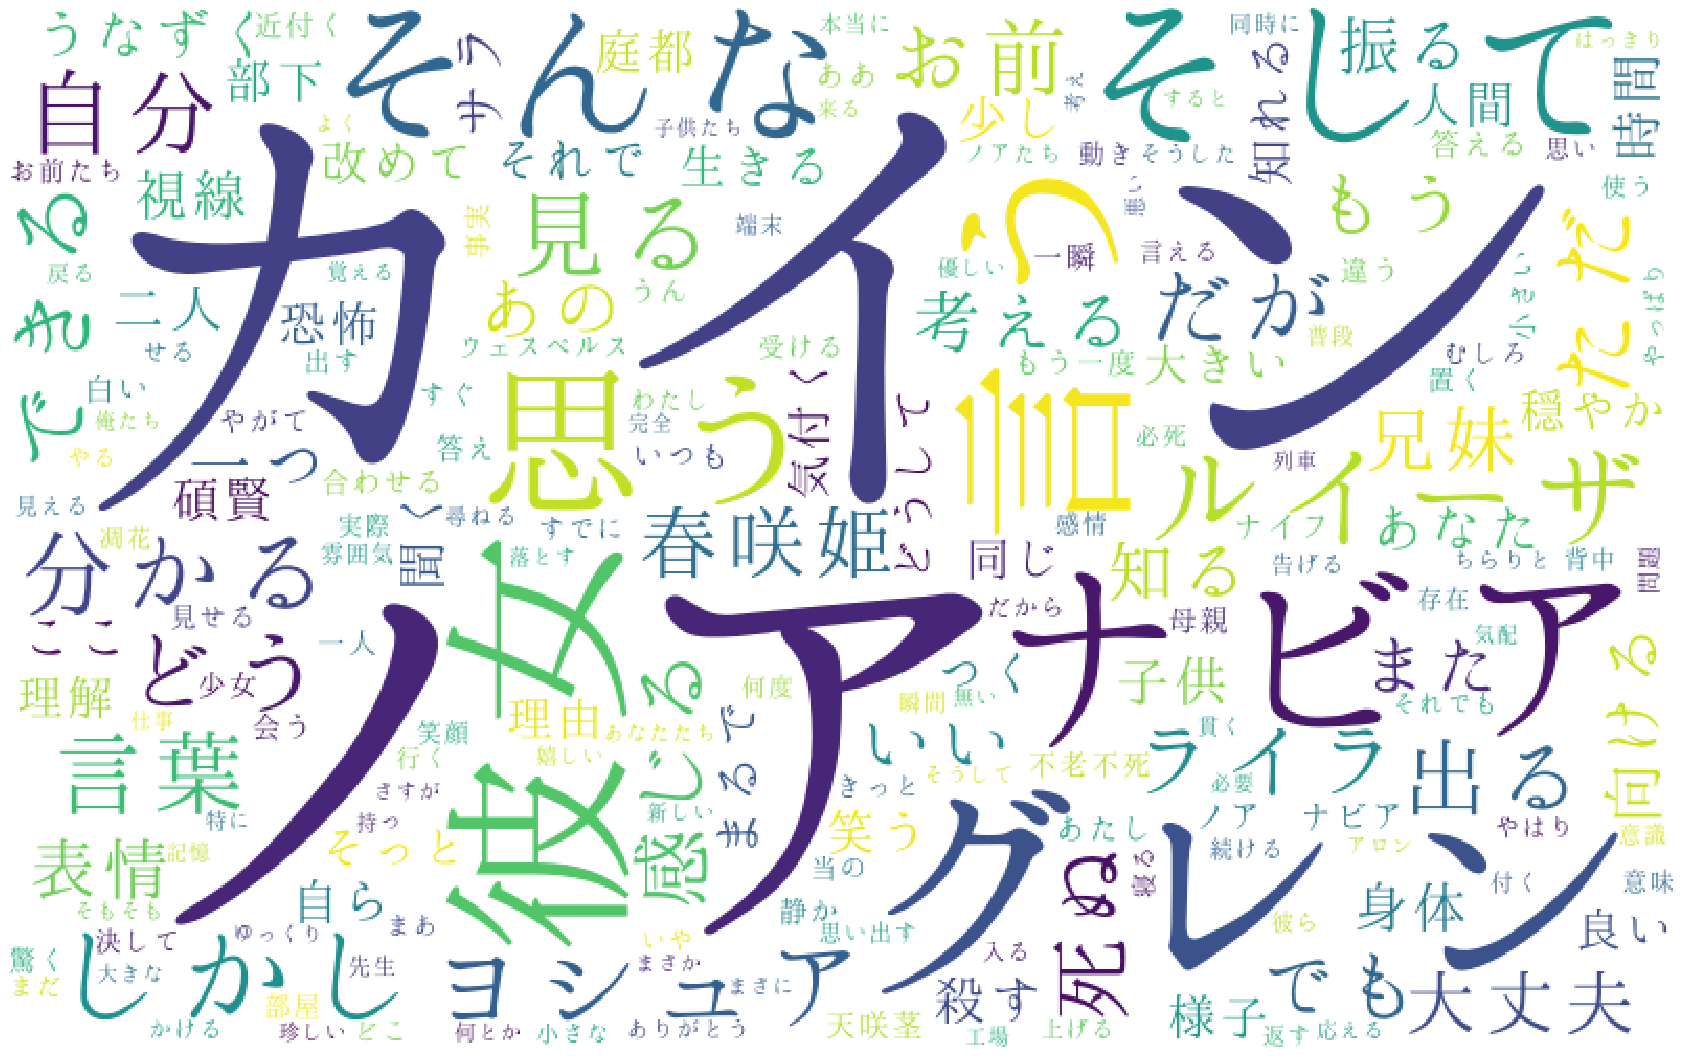

三章　万花の園に朽花一輪  ユニーク多め


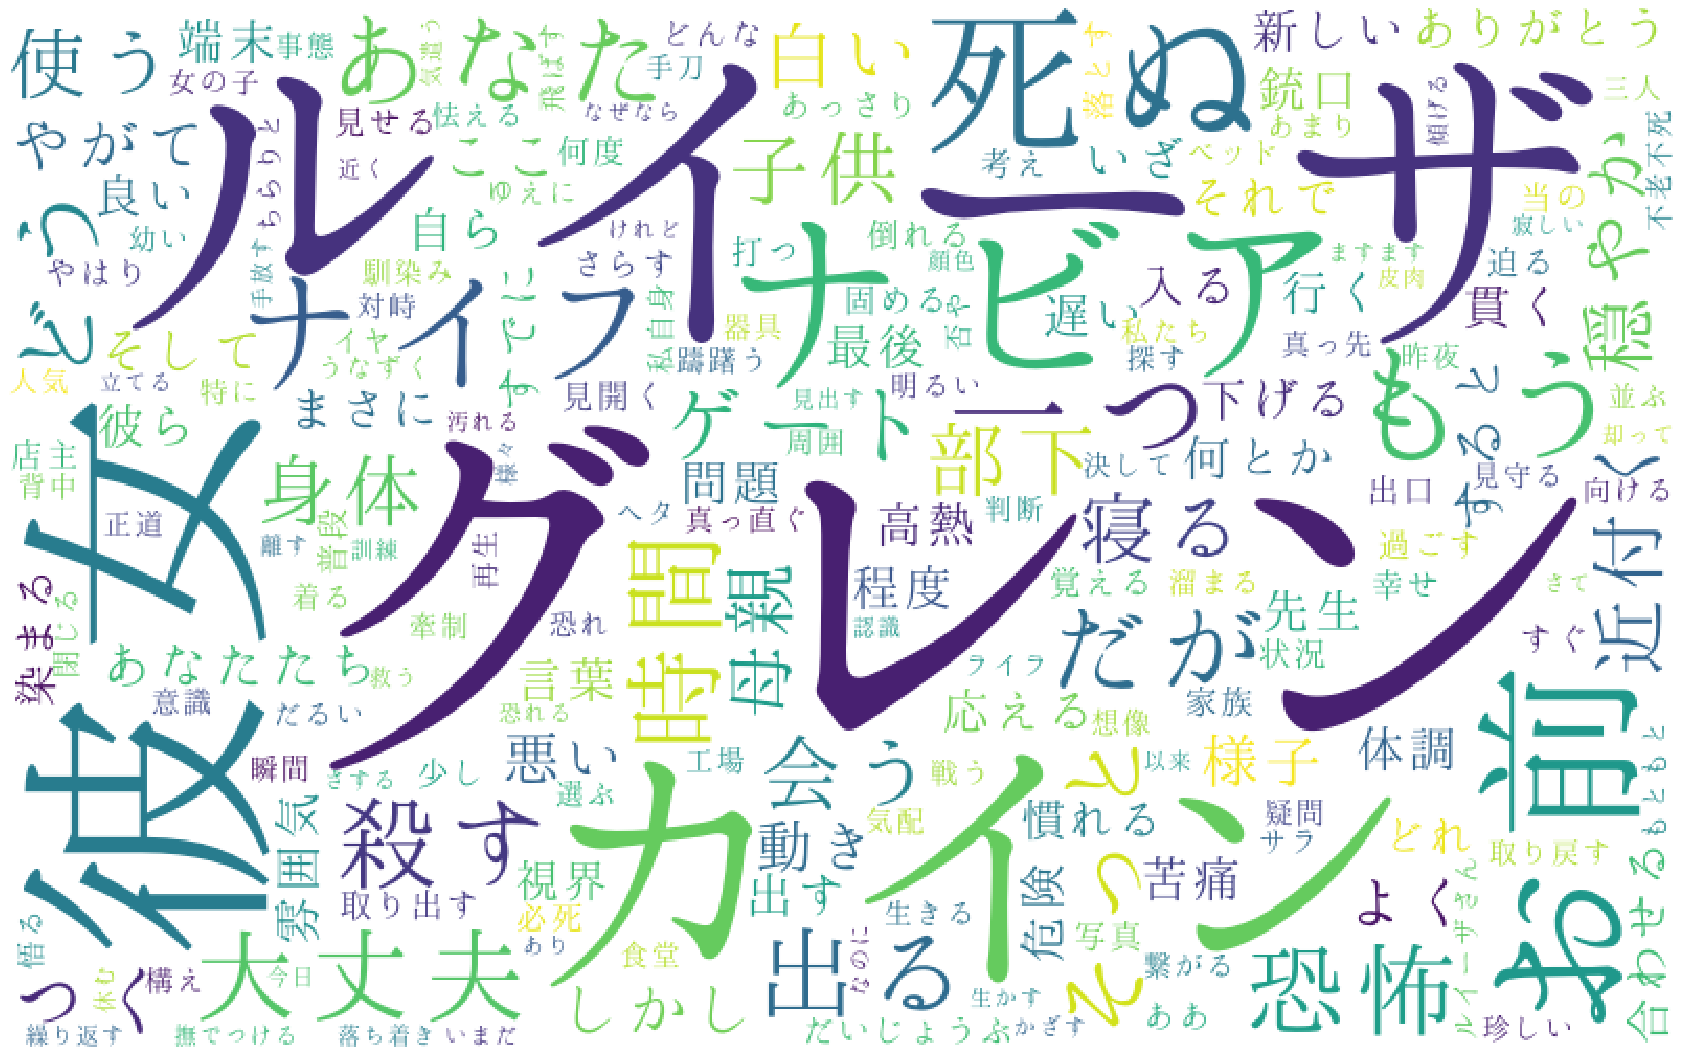

Counter({'――': 403, 'ノア': 125, 'カイン': 121, 'ナビア': 79, 'グレン': 75, '言う': 65, '彼女': 62, 'そして': 52, '何': 49, '私': 48, 'そんな': 48, '思う': 46, '死': 46, 'ルイーザ': 44, 'しかし': 42, '彼': 39, 'ヨシュア': 39, 'どう': 38, '顔': 37, '分かる': 35, '見る': 35, '今': 34, '手': 33, 'ただ': 33, '自分': 32, 'できる': 32, '人': 32, '目': 32, '言葉': 31, 'だが': 30, '出る': 27, '死ぬ': 27, 'お前': 27, 'あの': 27, 'ライラ': 26, '感じる': 25, '姿': 25, '春咲姫': 25, 'でも': 24, '大丈夫': 23, 'もう': 23, '兄妹': 23, 'いい': 23, '声': 21, '考える': 21, '子': 21, '表情': 20, 'また': 20, '知る': 20, '一つ': 20, '俺': 20, '首': 19, '前': 19, '心': 18, '振る': 18, '気': 18, '向ける': 18, 'うなずく': 18, 'あ': 18, 'サラ': 18, '身体': 17, '頭': 17, '子供': 17, '兄': 17, '視線': 17, '二人': 17, 'あなた': 17, '男': 17, '血': 16, '殺す': 16, 'ここ': 16, 'お': 16, '＊': 16, '時間': 16, '少し': 16, '命': 15, 'さ': 15, '人間': 15, '話': 15, 'まるで': 15, '聞く': 15, 'ナイフ': 15, '改めて': 14, '恐怖': 14, '笑う': 14, '生きる': 14, '知れる': 14, '自ら': 14, '碩賢': 14, '庭都': 14, 'つく': 14, '様子': 14, 'それで': 14, '動き': 14, '部下': 14, '大きい': 13, '理解': 13, '同じ': 13, '穏やか': 

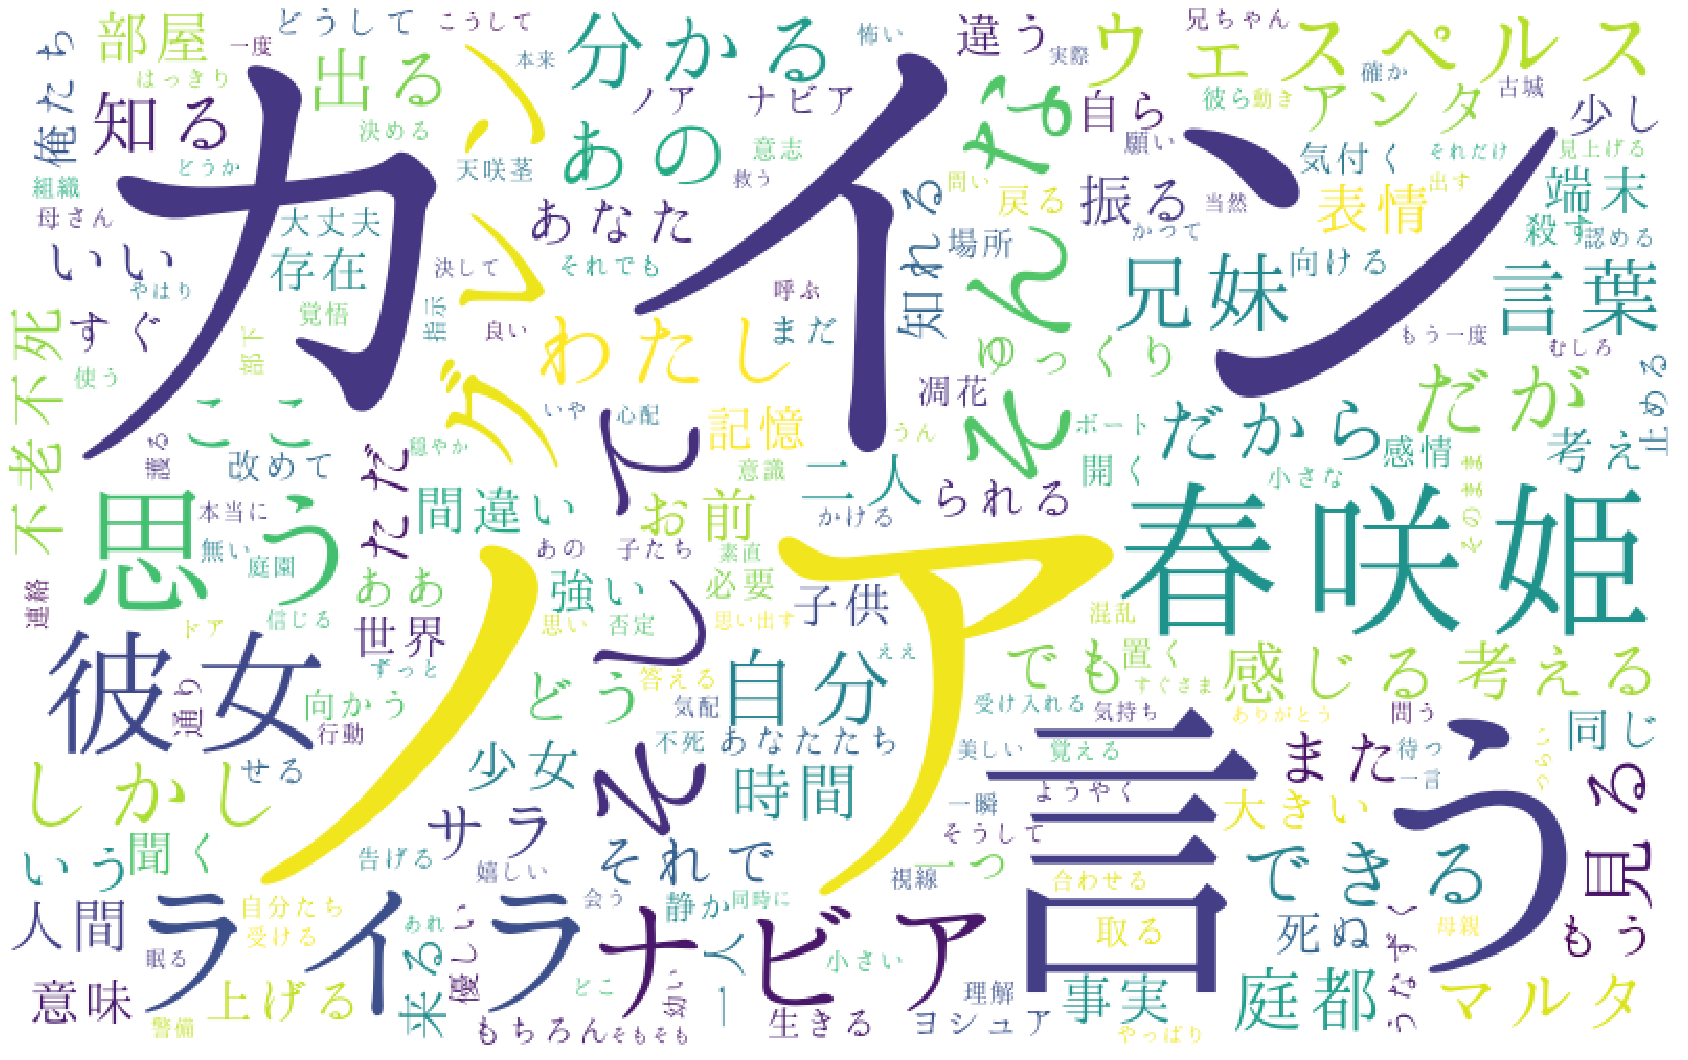

四章　祖花の想い、幼芽の願い  ユニーク多め


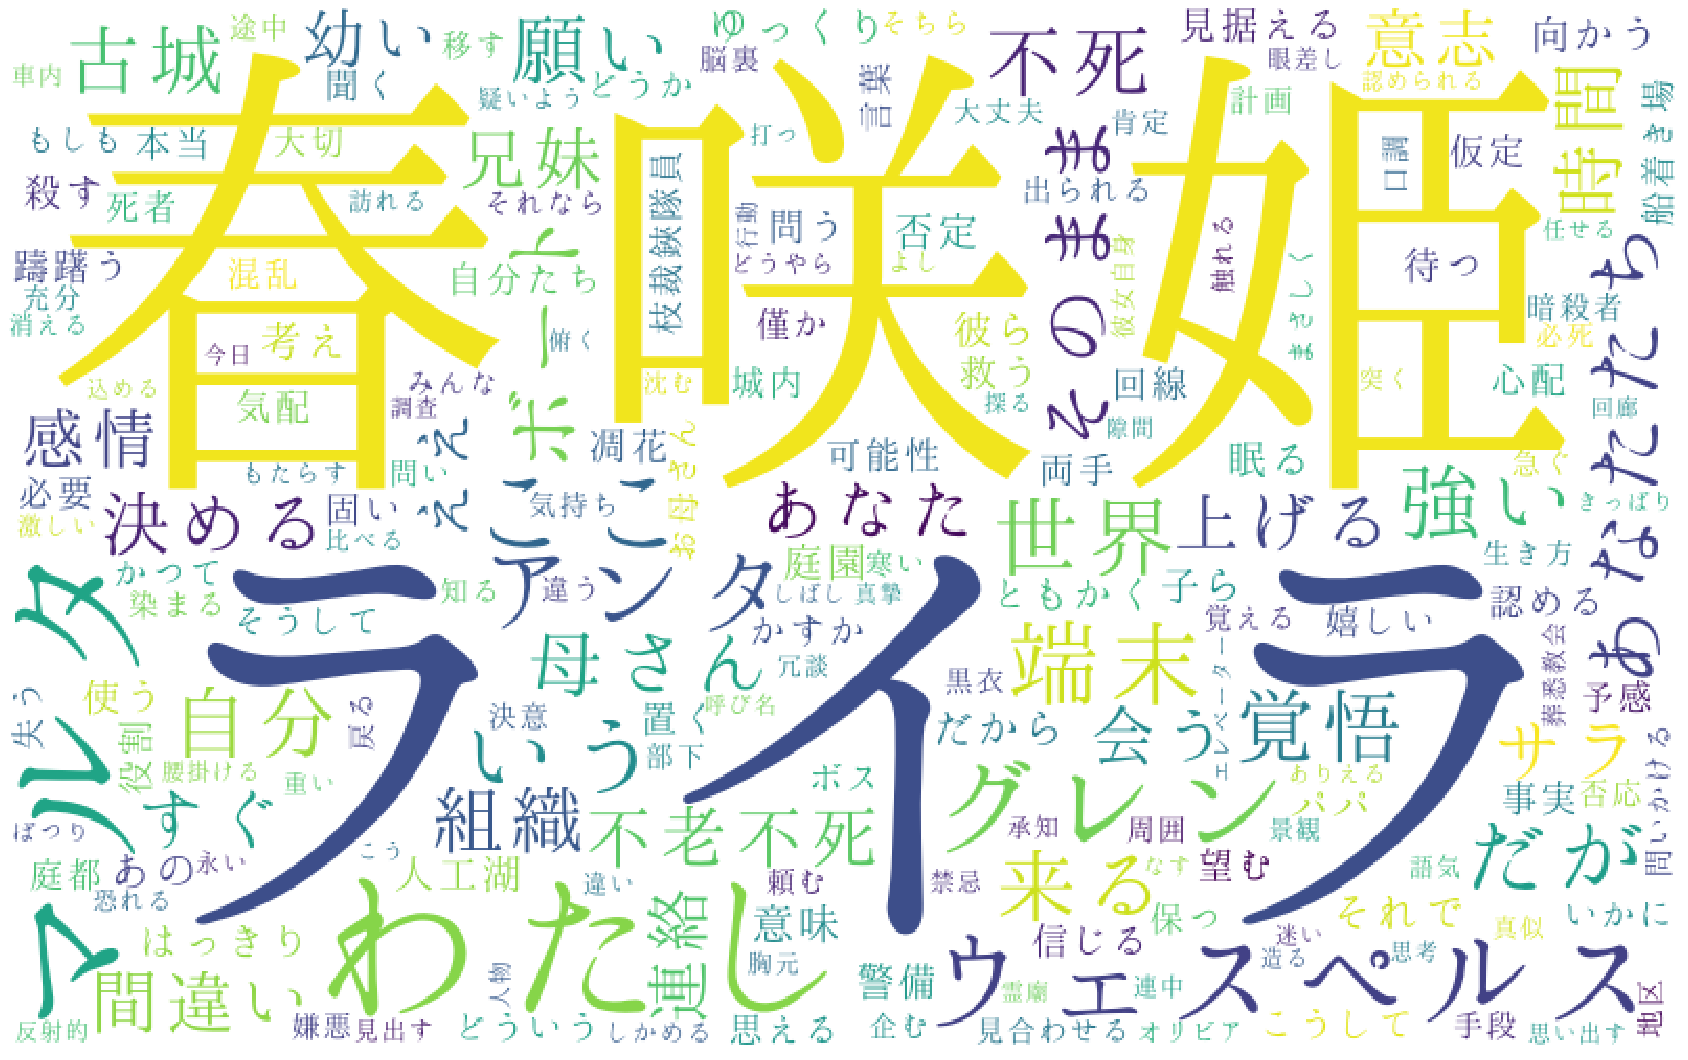

Counter({'――': 512, 'ノア': 152, 'カイン': 137, '言う': 102, '春咲姫': 102, 'ライラ': 85, 'ナビア': 81, 'そして': 76, '彼': 76, 'グレン': 74, '思う': 69, 'そんな': 69, 'あの': 68, '彼女': 66, '何': 57, 'ウェスペルス': 55, '分かる': 53, 'だが': 52, '自分': 50, '私': 48, '言葉': 48, '兄妹': 47, 'できる': 46, 'わたし': 46, 'しかし': 45, '今': 40, '手': 40, '見る': 38, '母': 38, '目': 37, '顔': 37, '＊': 37, '死': 36, 'だから': 36, 'ここ': 35, '出る': 32, '知る': 32, '声': 32, '庭都': 32, 'さ': 31, '感じる': 31, 'マルタ': 31, '人': 30, '俺': 30, 'サラ': 29, '口': 29, '身': 28, 'いい': 28, 'どう': 28, 'でも': 28, '考える': 28, '心': 27, 'また': 27, 'アンタ': 27, '時間': 26, '姿': 26, '先': 26, 'ただ': 26, '二人': 26, '命': 25, '不老不死': 25, '首': 25, 'それで': 25, '頭': 25, 'お前': 25, 'いう': 24, 'もう': 24, '来る': 24, '前': 24, '人間': 24, '話': 24, 'お': 24, '一つ': 23, '少女': 22, '表情': 22, '気': 22, '死ぬ': 22, '振る': 22, '間': 22, '部屋': 22, 'あなた': 22, '事実': 21, '知れる': 21, '間違い': 20, '子': 20, '誰': 20, '世界': 20, '開く': 20, 'うなずく': 20, '端末': 20, '不死': 20, '意味': 19, '理解': 19, 'ゆっくり': 19, 'ヨシュア': 19, '向ける': 19, '君': 19, '考え': 19, '上げ

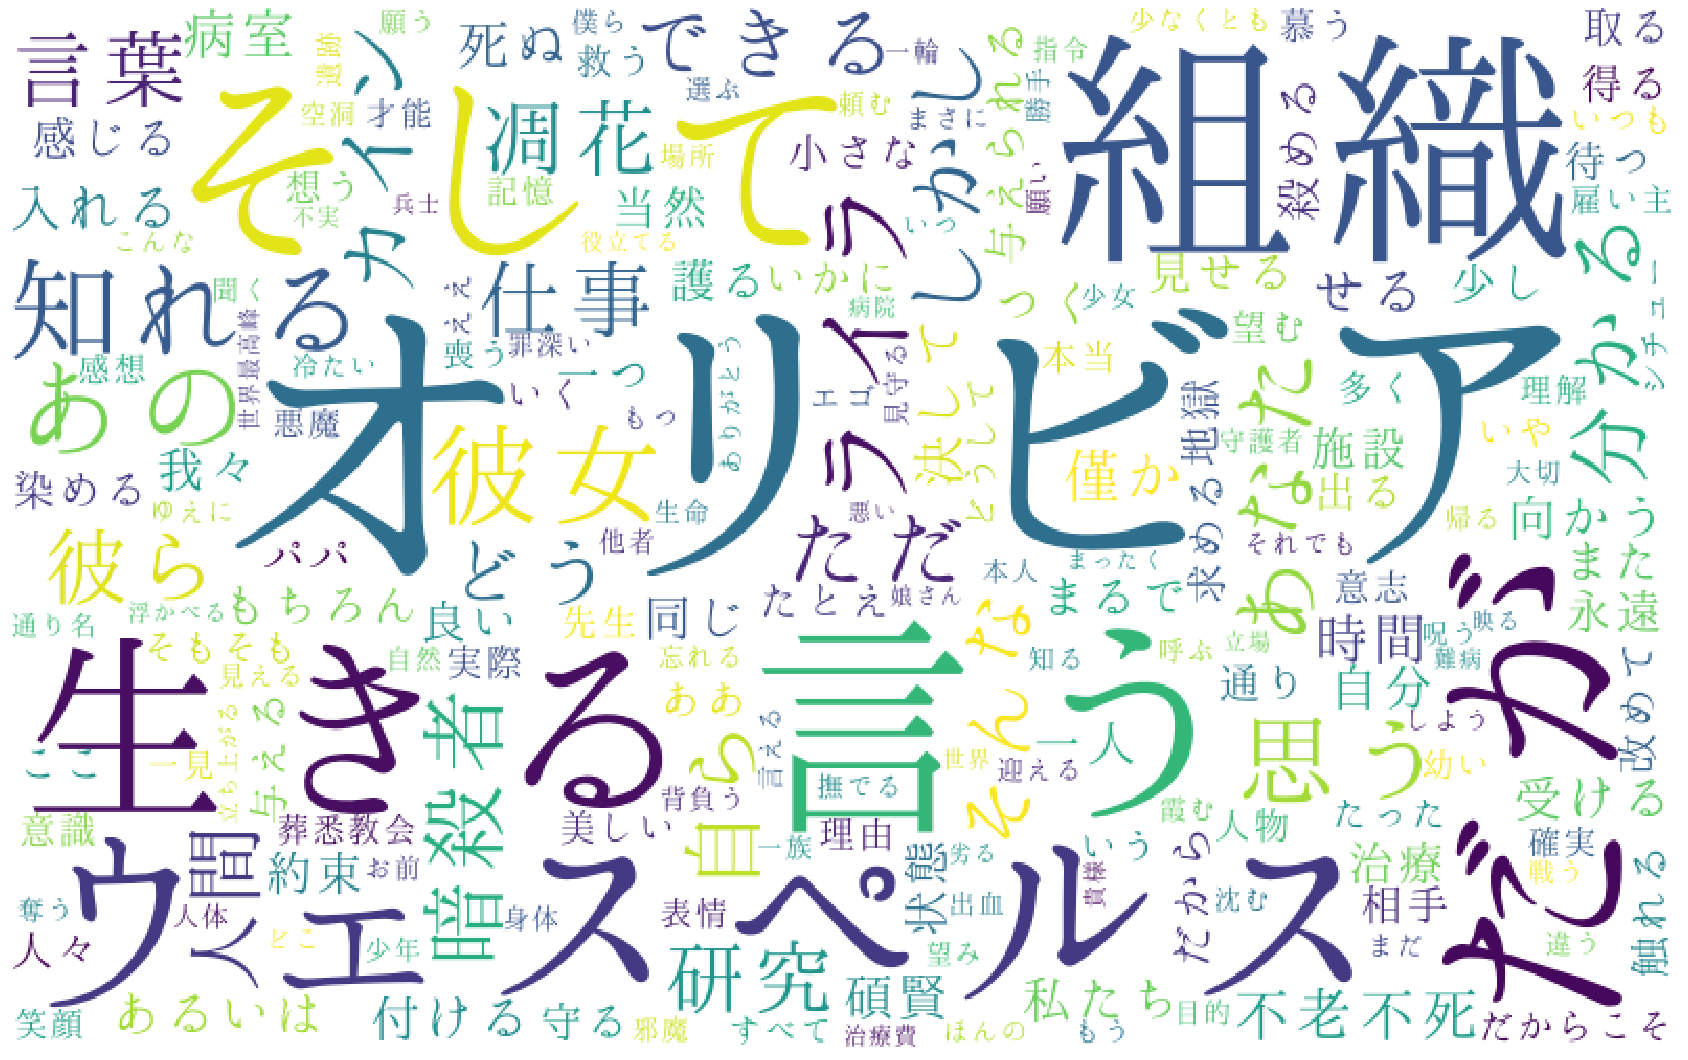

西暦２０ＸＸ年　～ある暗殺者の記憶～  ユニーク多め


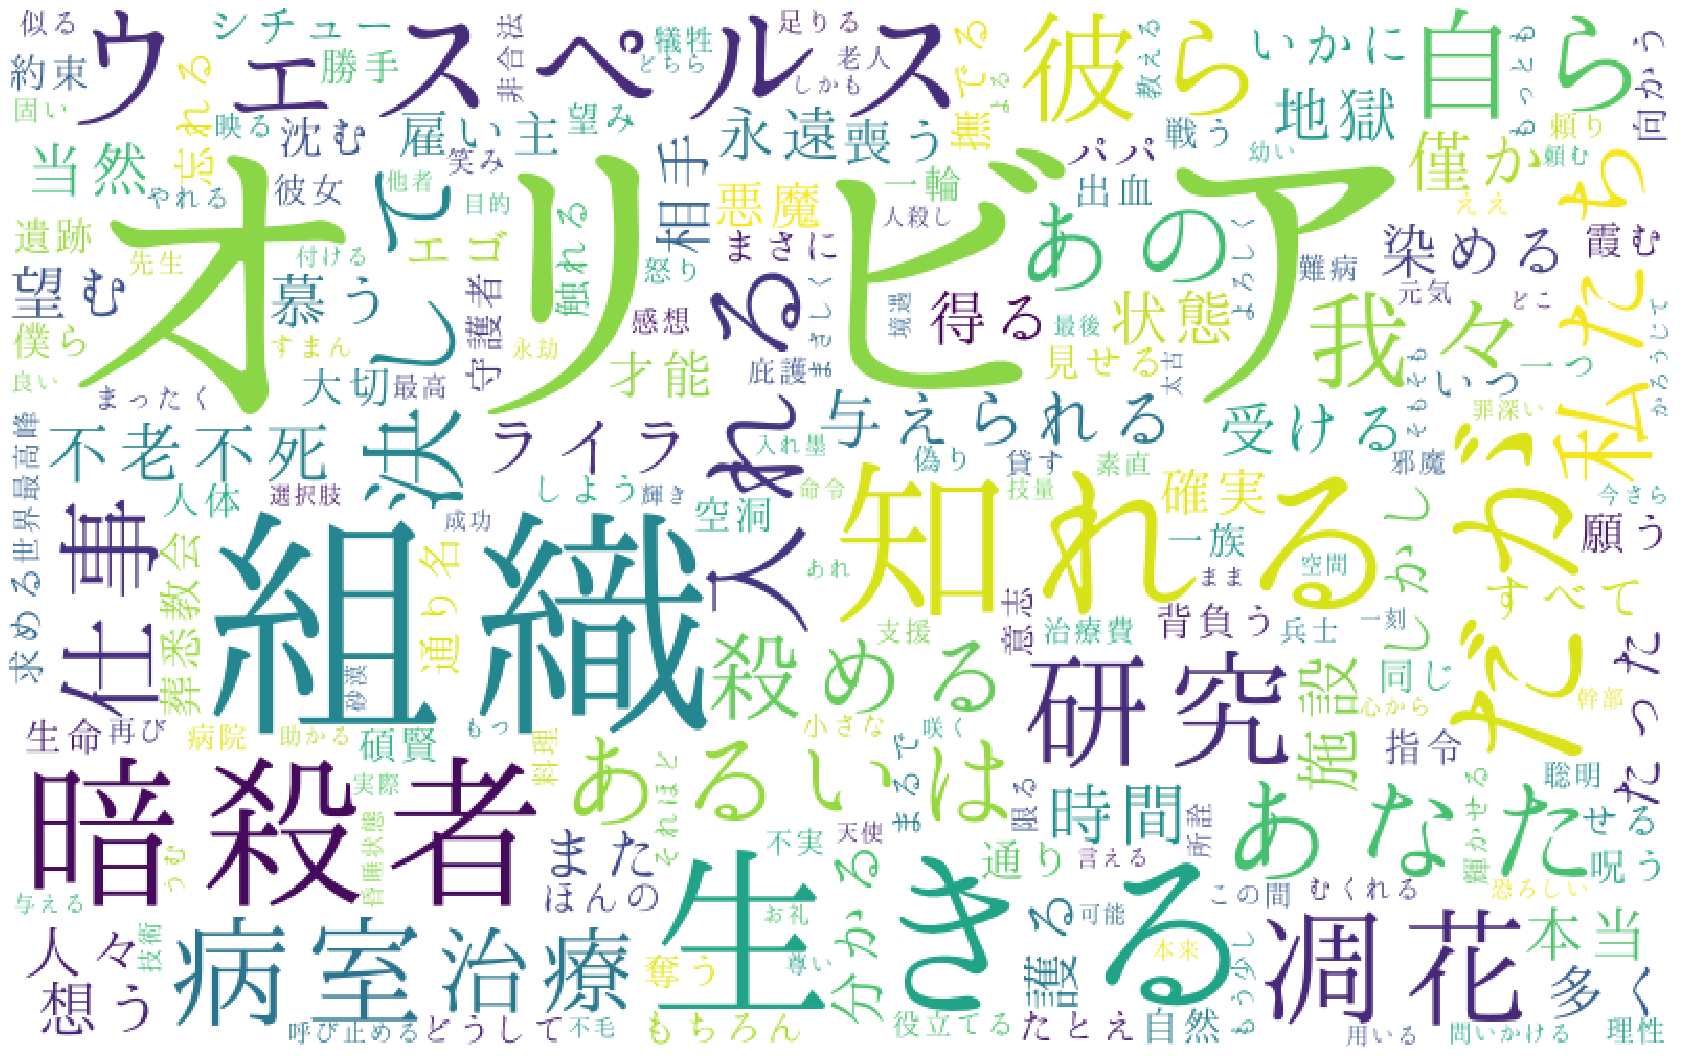

Counter({'――': 111, '私': 110, 'オリビア': 47, '組織': 25, '娘': 23, '言う': 23, 'だが': 22, '命': 21, 'そして': 20, '彼': 20, '花': 19, '生きる': 18, 'ウェスペルス': 18, '知れる': 17, 'あの': 17, '彼女': 17, '手': 15, 'ライラ': 15, '子': 14, '思う': 13, 'あなた': 12, '人': 12, '死': 12, 'しかし': 11, '不': 11, '心': 10, '何': 10, '暗殺者': 10, 'ただ': 10, '分かる': 10, 'カイン': 10, '男': 9, '今': 9, '仕事': 9, 'できる': 9, '自ら': 9, '彼ら': 9, '言葉': 9, 'そんな': 9, '凋花': 9, '人間': 8, 'どう': 8, '研究': 8, '不老不死': 8, '僅か': 8, '病室': 7, 'せる': 7, '決して': 7, '頭': 7, '時間': 7, '目': 7, '僕': 7, '死ぬ': 7, '入れる': 7, '罪': 7, '向かう': 6, '一人': 6, '受ける': 6, '我々': 6, '自分': 6, '妻': 6, '他': 6, '私たち': 6, '同じ': 6, 'つく': 6, 'あるいは': 6, '碩賢': 6, '付ける': 6, '血': 6, '間': 6, 'まるで': 5, '殺める': 5, '治療': 5, 'もちろん': 5, 'さ': 5, '当然': 5, '道': 5, '先': 5, '形': 5, '与えられる': 5, '施設': 5, '良い': 5, '約束': 5, '見せる': 5, '感じる': 5, '状態': 5, '一つ': 5, '少し': 5, 'また': 5, 'だから': 5, '護る': 5, '永遠': 5, '生': 5, '小さな': 4, '待つ': 4, '取る': 4, '話': 4, 'ああ': 4, 'いかに': 4, '相手': 4, '求める': 4, 'たとえ': 4, '地獄': 4, '守る': 4, 'ここ': 4, 

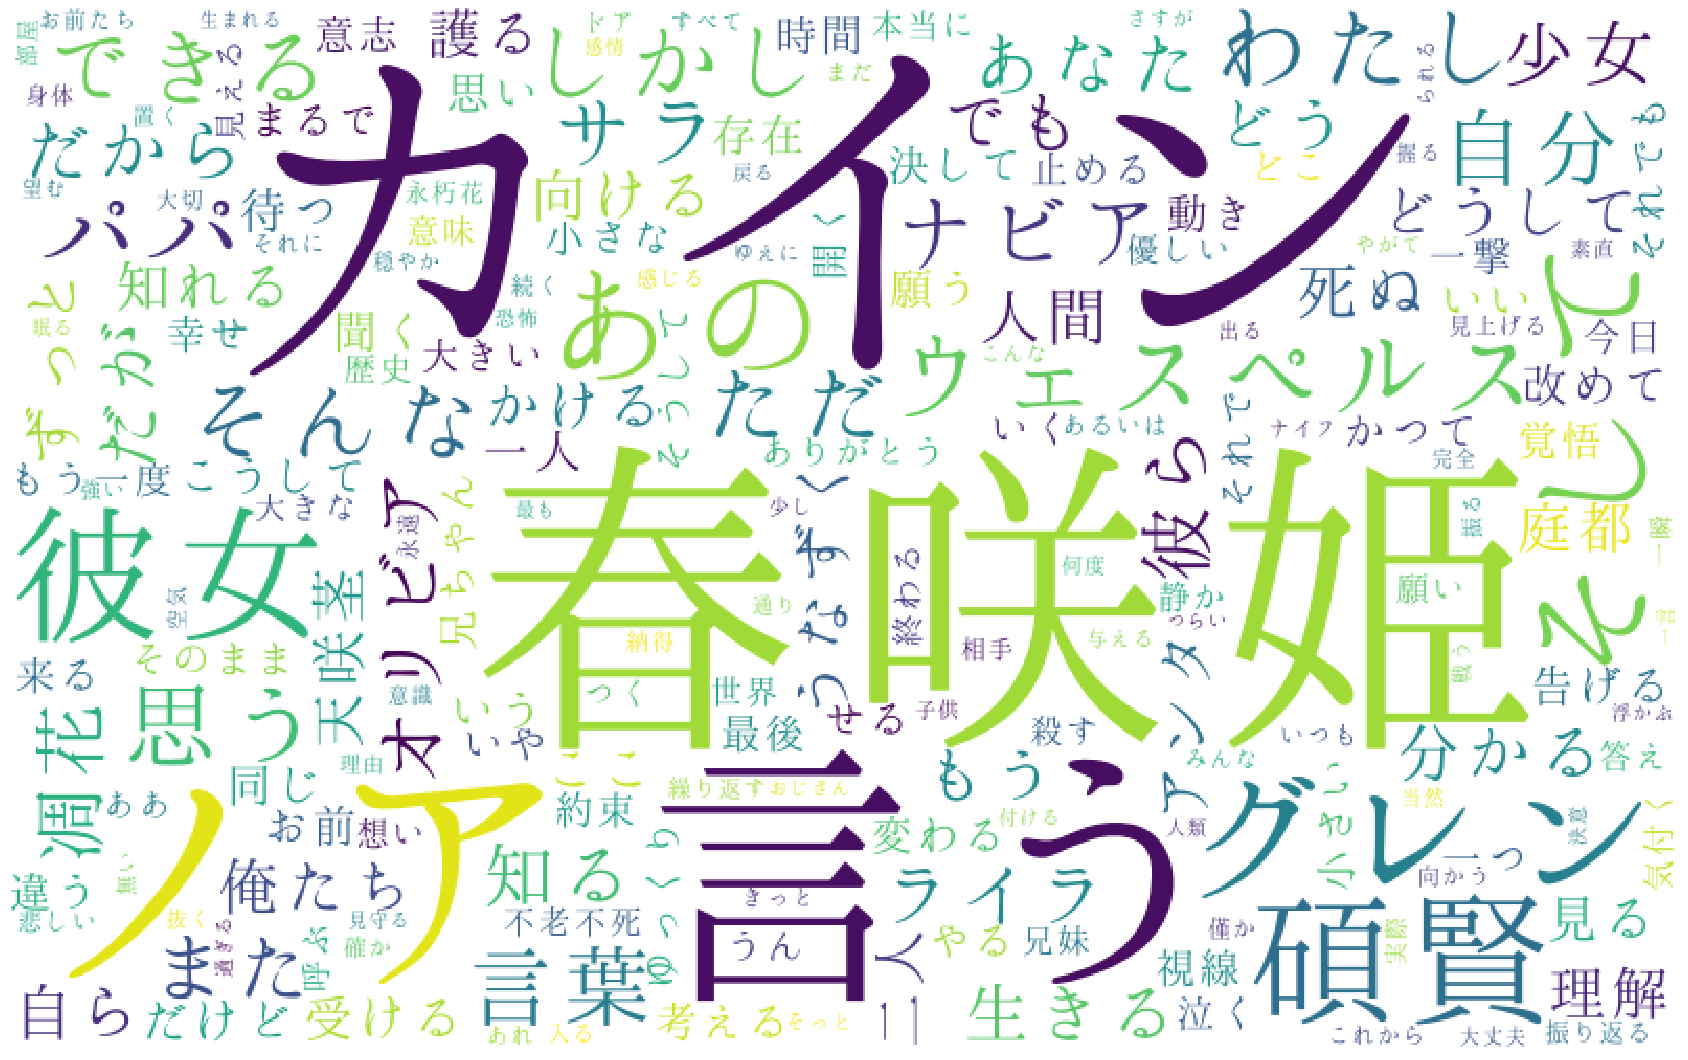

五章　そして、万花は楽園に還りゆく  ユニーク多め


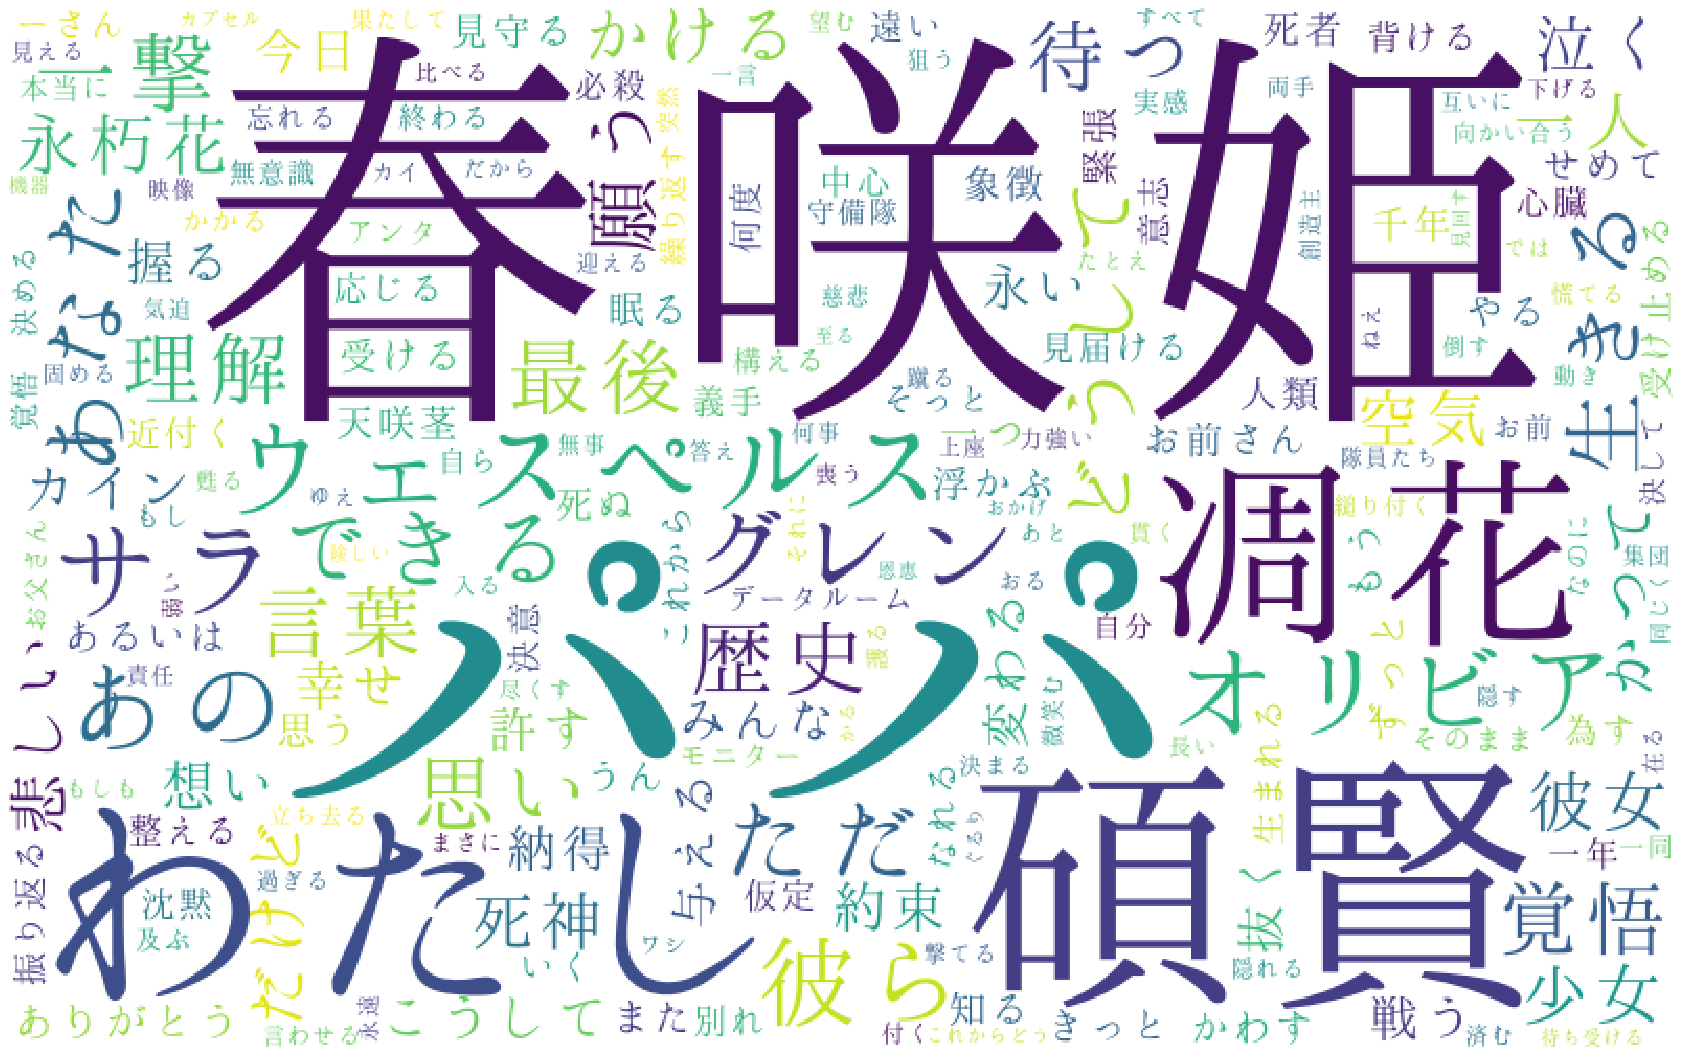

Counter({'――': 485, 'カイン': 123, '春咲姫': 87, '言う': 80, 'ノア': 74, 'グレン': 63, '僕': 62, '彼女': 61, '碩賢': 57, '死': 56, 'そして': 56, 'あの': 50, 'ウェスペルス': 49, 'できる': 45, 'わたし': 43, 'パパ': 43, 'そんな': 41, '思う': 41, '人': 41, 'しかし': 40, '手': 40, '言葉': 40, '何': 39, '目': 38, '今': 38, '私': 37, 'ただ': 37, '命': 36, '自分': 35, '不': 34, 'ナビア': 33, '凋花': 33, '彼': 30, '心': 30, 'サラ': 30, 'また': 29, '彼ら': 28, 'オリビア': 27, 'お': 27, 'だが': 26, '前': 26, 'あなた': 26, '少女': 26, 'だから': 25, '理解': 25, '知る': 25, 'もう': 25, 'ライラ': 25, 'でも': 24, '生きる': 23, '分かる': 22, '死ぬ': 21, 'どう': 21, 'うなずく': 21, 'ずっと': 21, 'どうして': 20, '俺たち': 20, '人間': 20, '先': 20, '自ら': 20, 'アンタ': 20, '姿': 20, '父': 20, '涙': 19, '覚悟': 19, '一つ': 18, '天咲茎': 18, '二人': 18, '向ける': 18, '力': 18, '一人': 18, '気': 17, '庭都': 17, 'かける': 17, '知れる': 17, '＊': 16, '口': 16, '護る': 16, 'ここ': 15, '見る': 15, '受ける': 15, 'だけど': 15, '間': 15, '誰': 15, '待つ': 15, 'さ': 14, '同じ': 14, '俺': 14, '顔': 14, '改めて': 14, 'こうして': 14, 'いい': 14, 'いう': 14, '聞く': 14, '声': 14, '思い': 14, '場': 14, '娘': 14, 'お前

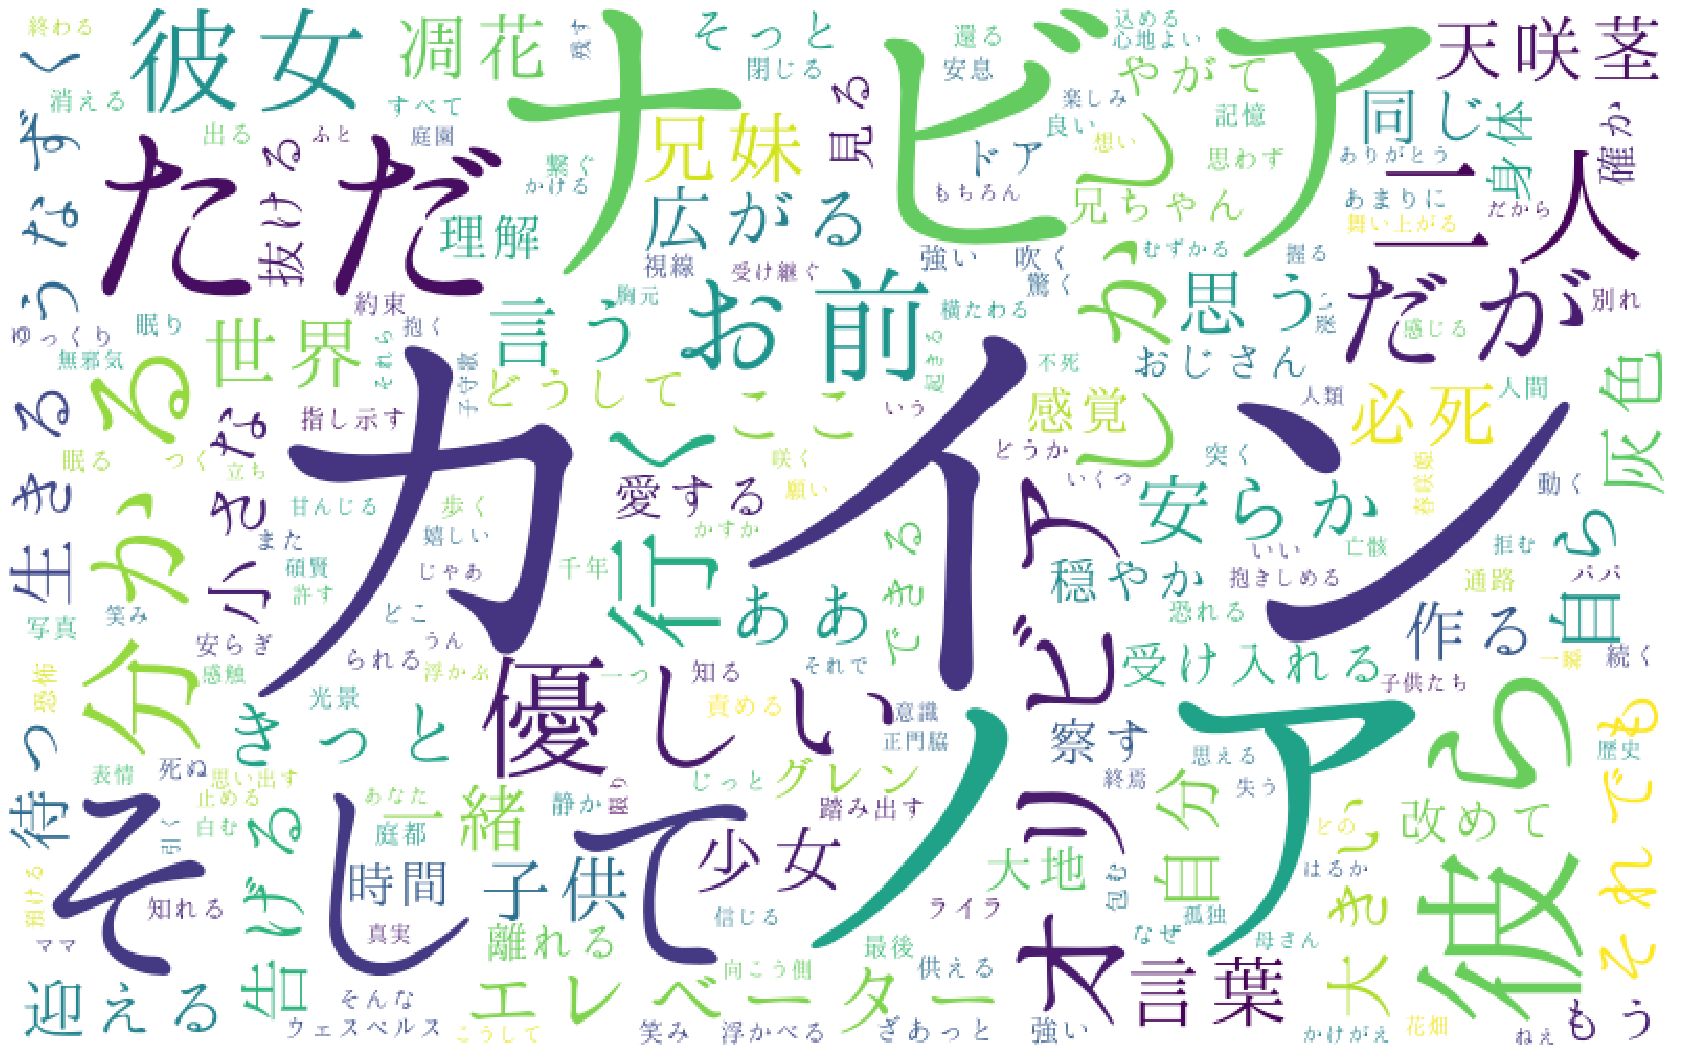

終章　新たな花を咲かせるために  ユニーク多め


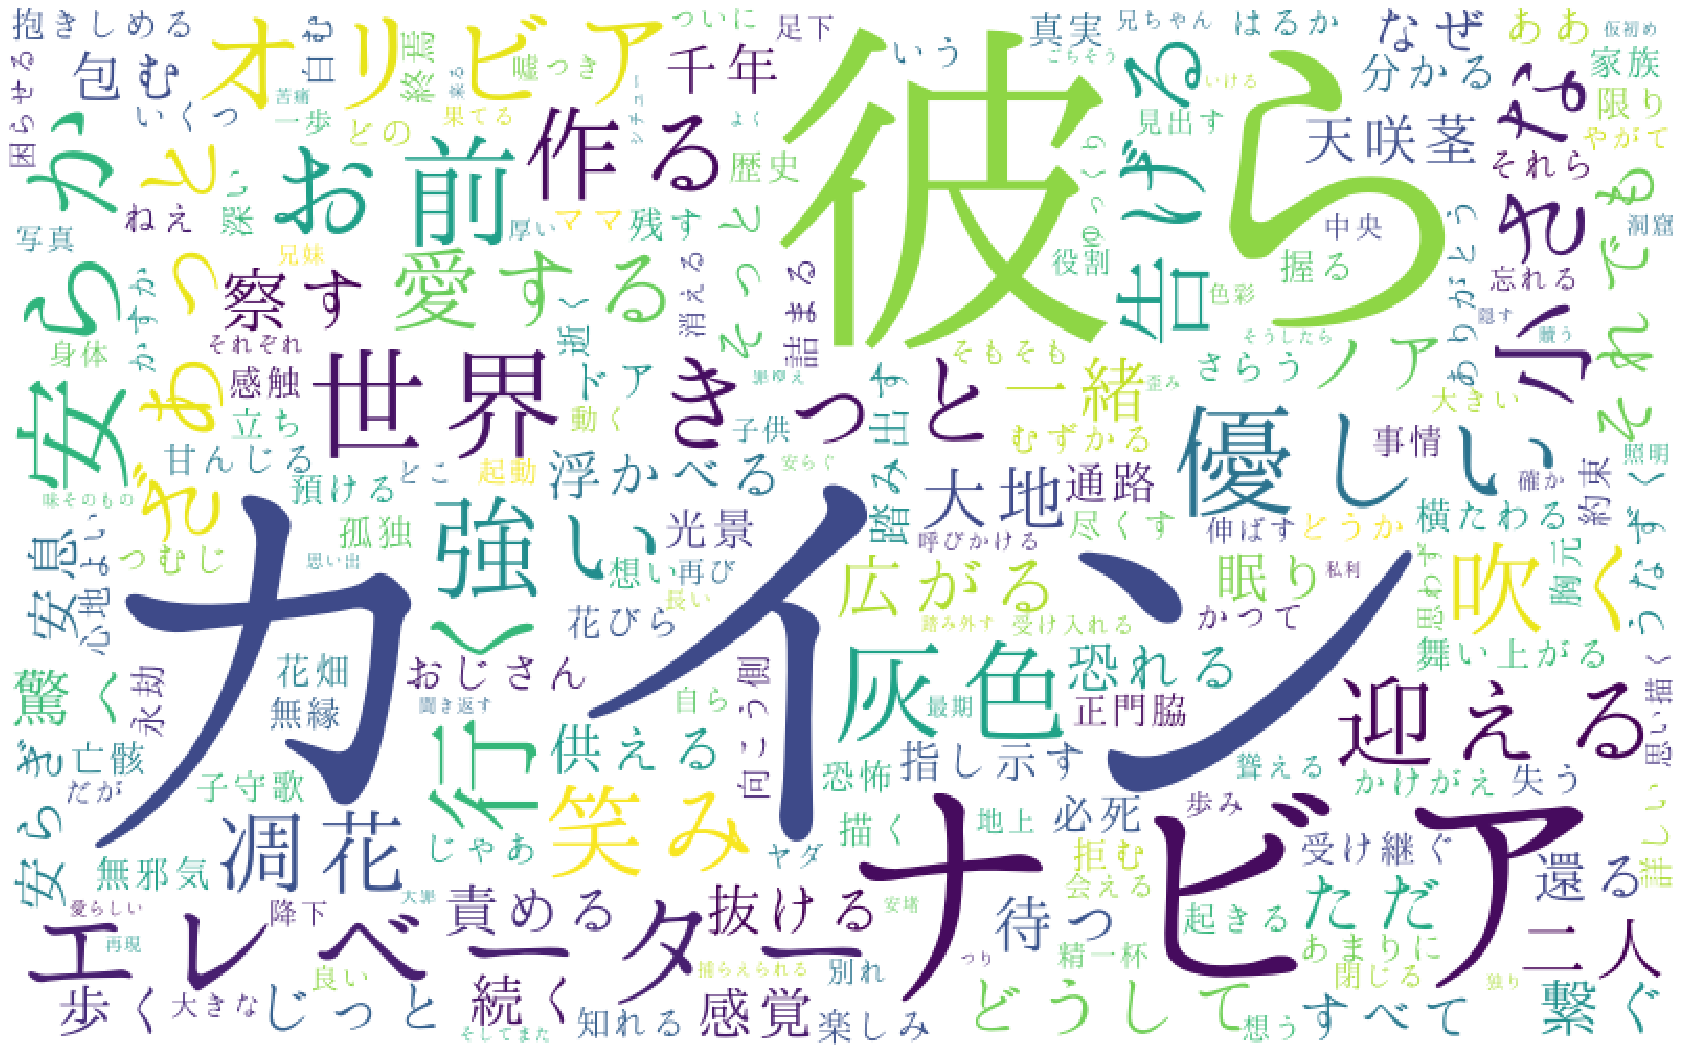

Counter({'――': 114, 'カイン': 34, 'ノア': 20, 'ナビア': 17, '彼': 17, 'そして': 16, '手': 14, 'ただ': 12, '娘': 12, '死': 12, '彼ら': 9, '優しい': 9, 'オリビア': 9, '花': 9, '二人': 9, '分かる': 9, '力': 8, 'お前': 8, '命': 8, 'だが': 8, 'しかし': 8, '行く': 8, '彼女': 7, '姿': 7, 'エレベーター': 7, '強い': 6, 'きっと': 6, '自ら': 6, '妻': 6, '言う': 6, '言葉': 6, '先': 6, '安らか': 6, '世界': 6, '兄妹': 6, '風': 5, 'それでも': 5, '天咲茎': 5, '広がる': 5, '大きい': 5, '少女': 5, '顔': 5, '笑み': 5, '一緒': 5, '人': 5, '罪': 5, '告げる': 5, 'ああ': 5, '何': 5, 'うなずく': 5, '生きる': 5, '小さな': 5, '身': 5, 'お': 5, '不': 5, '凋花': 5, '子供': 5, '今': 5, '自分': 5, '必死': 5, '思う': 5, 'ここ': 5, '光': 5, '灰色': 5, 'ざあっと': 4, '吹く': 4, '場': 4, '待つ': 4, '空': 4, '下': 4, '心': 4, '同じ': 4, '迎える': 4, '作る': 4, '微': 4, '受け入れる': 4, 'そっと': 4, 'やがて': 4, '愛する': 4, '改めて': 4, '穏やか': 4, '身体': 4, '抜ける': 4, 'できる': 4, '感覚': 4, '時間': 4, 'どうして': 4, 'もう': 4, '大地': 4, '理解': 4, '察す': 4, '見る': 4, 'グレン': 4, 'おじさん': 4, '離れる': 4, 'ドア': 4, '兄ちゃん': 4, '声': 4, '確か': 4, '動く': 3, '繋ぐ': 3, 'じっと': 3, '恐怖': 3, 'パパ': 3, '驚く': 3, '浮かべる': 3, '私':

In [9]:
syosetu_list = scr_cloud_txt("https://ncode.syosetu.com/n8703fv/")##, chap_bool=True, not_serial=True)

In [12]:
## 能力は平均値 
syosetu_list = scr_cloud_txt("https://ncode.syosetu.com/n6475db/",chap_bool=False)

01 転生　１
02 転生　２
03 学園へ
04 能力は平均値で
05 私は普通の女の子です　１
06 私は普通の女の子です　２
07 Ａクラス
08 友達　１
09 友達　２
10 武術訓練
11 魔法訓練
12 灼熱の男　１
13 灼熱の男　２
14 今度は死なないよ！
15 女神顕現
16 逃亡
17 糾弾
18 新米ハンター
19 初仕事
20 勧誘
21 また学校ですか？
22 王都へ
23 ハンター養成学校
24 ルームメイト
25 会議
26 実技訓練
27 金欠
28 養殖
29 身代わり地蔵
30 パワーレベリング
31 赤き誓い
32 卒業検定　１
33 卒業検定　２
34 卒業検定　３
35 卒業検定　４
36 ワンダーでミラクルなマジック少女達
37 キャットファイト
38 普通のＣランクハンター
39 新たな武器
40 新たな武器　リベンジ編
41 打開策
42 限界への挑戦
43 寄生
44 岩トカゲ
45 反省
46 ロックゴーレム
47 帰還
48 依頼主
49 販売
50 護衛
 51 合同任務
52 釣り
53 盗賊
54 過去
55 赤のレーナ
56 敵
57 戦い
58 接近戦
59 尋問
60 帰路
61 王都への帰還
62 お披露目
63 襲撃
64 反撃
65 逆襲
66 臨時編成
67 作戦
68 討ち入り
69 弾劾
70 ポーさん、レーさん、やっておしまいなさい！
71 新たなる戦い
72 謎のお師匠様
73 伯爵対お師匠様
74 覚醒
75 兄妹対決
76 これからどうしよう？
77 凱旋
78 閑話
79 ひみつハンター　ワンダーⅢ
80 新たな依頼
81 ワイバーンとの戦い・・・情報収集
82 ワイバーンとの戦い・・・準備完了！
83 ワイバーンとの戦い・・・好敵手
84 ワイバーンとの戦い・・・苛めじゃないよ？
85 ワイバーンとの戦い・・・聞いてないよ！
86 ワイバーンとの戦い・・・激闘
87 怪しい男
88 事情
89 企み
90 依頼完了！
91 新章　あれから１６年・・・
92 出撃！
93 遭遇
94 追跡
95 暗闇からこんばんは
96 脱出！
97 悪魔の所業
98 状況
99 激闘！　暁の戦い　１
100 激闘！　暁の戦い　２
101 訊問
102 骨折り仕事
103 領都へ
104 そ

TypeError: can only concatenate str (not "Tag") to str

In [ ]:
t = Tokenizer()
[print(token) for token in t.tokenize(c)]

In [14]:
a = "今日"+""+"は"+""+"|いい｜天気《テンキ》"
b = re.sub(r"\||｜|《.*》","",a)
b

'今日はいい天気'

In [21]:
c = 'そこではたと動きを止める。'

In [33]:
dica = {"a": 10}
dica.items()

dict_items([('a', 10)])